# Data Preparation and Analysis Notebook
## Defining the representation, data extraction, cleaning, preprocessing, and visualisation

In this Jupyter notebook we first need to define the representation that we will be using for our model.

One approach is to consider the fragmentation of the tumour via its cancer cells. If the cancer cells are highly clustered, then the T cells will have an easier time containing their spread and thus reducing the likelihood of penetration into the bloodstream. If this happens then the cancer can spread rapidly and increase the likelihood of a fatality. 

Following from this idea of fragmentation, the idea is to define a neighbouring relation between cells. If they are close enough to each other, we say that they are in the same 'bud', or 'cluster'. A cluster is then defined as a collection of cells where for each c in the cluster, there exists another cell c' such that c and c' are neighbours according to our neighbouring relation.

We'll take a histogram of the frequencies of the sizes of these clusters, from 1 to 20 and 21+. This gives us a homogenous, relatively low-dimensional (n=21) input to our classifier.

## TODO: Clarify the different types of data ## 
The data is passed in as a large Excel file with various fields. Once those were cleaned up, we had just 8 columns, being xMin, xMax, yMin, yMax of the bounding boxes surrounding the cells, and three classes indicating whether the cell was a cancer cell, a general T cell, or a cytotoxic T cell. Note that 'lymphocytes' are a superset of T cells.

Now that we've defined a feature representation to give to our model, let's go about getting our representation.

In [ ]:
# Watermark for reproducibility of results
%load_ext watermark
%watermark -a 'Daniel Soutar' -d -nrmv --packages numpy, pandas,sklearn,matplotlib,seaborn,imblearn

In [1]:
# Imports
import Cluster
import csv
import cProfile
import glob
import Loader
import partition
import pickle
import strip
import Visualiser
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm, trange

import pandas as pd
import seaborn as sb
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.preprocessing import StandardScaler

# Note to self: reference this in final report submission.
# @article{JMLR:v18:16-365,
# author  = {Guillaume  Lema{{\^i}}tre and Fernando Nogueira and Christos K. Aridas},
# title   = {Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning},
# journal = {Journal of Machine Learning Research},
# year    = {2017},
# volume  = {18},
# number  = {17},
# pages   = {1-5},
# url     = {http://jmlr.org/papers/v18/16-365}
# }

In [ ]:
## Loading
example = open("./LargerDataset/2016_12_17__0712(ext).czi_3090_job2883.object_results.p", 'rb')
input_list = pickle.load(example)
example.close()
print(len(input_list))

In [ ]:
# Splitting cells up by their class
cancer_cells = []
T_cells = []
cyto_T_cells = []

for i, row in enumerate(input_list):
    conv_row = [ int(x) for x in row[0:-1] ]
    conv_row.append(float(row[-1]))
    
    if conv_row[4] > 0 and conv_row[-1] > 50.0:  # filter out cells that are too small - those are blood cells!
        cancer_cells.append([conv_row[0], conv_row[1], conv_row[2], conv_row[3]])
    if conv_row[5] > 0:
        T_cells.append([conv_row[0], conv_row[1], conv_row[2], conv_row[3]])
    if conv_row[6] > 0:
        cyto_T_cells.append([conv_row[0], conv_row[1], conv_row[2], conv_row[3]])
        
cancer_cells = np.asarray(cancer_cells)
T_cells = np.asarray(T_cells)
cyto_T_cells = np.asarray(cyto_T_cells)
print(cancer_cells.shape)

In [ ]:
clusters_input_list = Loader.load_data("2016_12_17__0745(ext).czi_3122_job2916.object_results", "./LargerDataset/")

cancer_clusters = Loader.split_clusters(clusters_input_list)
Visualiser.visualise_clusters(cancer_clusters)

lymphocytes_input_list = Loader.load_lymphocytes("2016_12_17__0745.czi_405_job2753.object_results", "./lymphocytes/")

cd3, cd8 = Loader.split_lymphocytes(lymphocytes_input_list)
Visualiser.visualise_lymphocytes(cd3, cd8)

# print(max(cd8[:, 3]))

In [ ]:
print(max(cd3[:,3]))
print(max(cd8[:,3]))

In [ ]:
# Let's first visualise the input to make sure our data 'looks' as we would expect it to.
cancer_cells_xAvg = np.mean(np.array([cancer_cells[:,0], cancer_cells[:,1]]), axis=0)
cancer_cells_yAvg = np.mean(np.array([cancer_cells[:,2], cancer_cells[:,3]]), axis=0)

T_cells_xAvg = np.mean(np.array([T_cells[:,0], T_cells[:,1]]), axis=0)
T_cells_yAvg = np.mean(np.array([T_cells[:,2], T_cells[:,3]]), axis=0)

cyto_T_cells_xAvg = np.mean(np.array([cyto_T_cells[:,0], cyto_T_cells[:,1]]), axis=0)
cyto_T_cells_yAvg = np.mean(np.array([cyto_T_cells[:,2], cyto_T_cells[:,3]]), axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

ax1.set_title('Cancer cells', fontsize=30)
ax1.scatter(cancer_cells_xAvg, cancer_cells_yAvg, s=0.1, c='b')

ax2.set_title('T cells', fontsize=30)
ax2.scatter(T_cells_xAvg, T_cells_yAvg, s=0.1, c='r')

ax3.set_title('Cytotoxic T cells', fontsize=30)
ax3.scatter(cyto_T_cells_xAvg, cyto_T_cells_yAvg, s=0.1, c='g')

plt.show(fig)

Now let's move the above functionality into some functions. Note that we have several different kinds
of data and might want to filter our data. So let's use lambdas and several input formats to filter in 
a generic way.

In [ ]:
def load_split_visualise(src, path, fxMin=None, fxMax=None,
                         fyMin=None, fyMax=None,
                         fcell_size=lambda x : x >= 50.0,
                         fnum_cells=lambda x : x > 0,
                         input_type="mixed",
                         single_image=False):
    
    print(src)
    if input_type.lower() == "mixed":
        cancer_cells, T_cells, cyto_T_cells = Loader.load_split(src, path, fxMin=fxMin, fxMax=fxMax,
                                                                fyMin=fyMin, fyMax=fyMax, fcell_size=fcell_size, input_type=input_type)
        Visualiser.visualise_mixed_cells(cancer_cells=cancer_cells, T_cells=T_cells,
                              cyto_T_cells=cyto_T_cells, single_image=single_image)
    elif input_type.lower() == "cluster":
        cancer_clusters = Loader.load_split(src, path, fxMin=fxMin, fxMax=fxMax,
                                    fyMin=fyMin, fyMax=fyMax, fnum_cells=fnum_cells, input_type=input_type)
        Visualiser.visualise_clusters(cancer_clusters)
    elif input_type.lower() == "lymphocyte":
        input_list = Loader.load_split(src, path, fxMin=fxMin, fxMax=fxMax, fyMin=fyMin, fyMax=fyMax, input_type=input_type)
        Visualiser.visualise_lymphocytes(cd3_cells, cd8_cells)
    print()

Let's visualise a few more samples!

In [ ]:
# load_split_visualise("_DONEIN700-SN142.p", fyMax=lambda x : x < 30000, fcell_size=lambda x : x >= 50.0, single_image=True)
# load_split_visualise("_outDONEIN801-SN125.p")
# load_split_visualise("_outDONEIN803-SN166.p")
# load_split_visualise("_outDONEIN804-SN167.p")
# load_split_visualise("_outDONEIN805-SN126.p")

load_split_visualise("2016_12_17__0700-1(ext).czi_3079_job2870.object_results", path="./LargerDataset/", fnum_cells=lambda x : x > 0, input_type="cluster")

# input_list = load_lymphocytes("2016_12_17__0690.czi_3064_job2860.object_results", "./lymphocytes/")

# cd3, cd8 = split_lymphocytes(input_list)

# print(cd3.shape)
# print(cd8.shape)

Now that we have our cells separated and visualised, let's go about clustering them together! But given that we don't necessarily know what we should expect our answers to be (i.e. there is no blindingly obvious answer as to how many clusters of each type we should expect exactly). So we should first test our clustering code to establish correctness and sanity-checking the results.

We could use k-means clustering (KMC), but the problem is that in order to use it we must provide k as a parameter. But we don't know what k is! Additionally, to get reliable results with KMC it is often recommended to restart several times. On such big files, that is hideously slow and hence unlikely to scale well.

Therefore I have used what I like to call the "simplest" and "Fisherman's" algorithms for extracting clusters of cancer cells. The algorithms are described in Cluster.py.

I test these algorithms on randomly generated inputs below. This was extremely useful when I was trying to visualise results and construct test cases for test.py.

In [ ]:
# Example cases for clustering algorithms - this is where I visualised the various inputs for test.py
NUM_POINTS = 1000

check_again = False

if not check_again:
    random_xMin = np.random.choice(range(NUM_POINTS + 1), size=NUM_POINTS, replace=False)
#     random_xMin = np.arange(NUM_POINTS)
    random_xMax = np.copy(random_xMin) + 3
    random_yMin = np.random.choice(range(NUM_POINTS + 1), size=NUM_POINTS, replace=False)
#     random_yMin = np.arange(NUM_POINTS)
    random_yMax = np.copy(random_yMin) + 3
    random_points = np.stack((random_xMin, random_xMax, random_yMin, random_yMax), 0).transpose()

t = 25
Cluster.set_d(7)
partitioned_random_points, windows_list, w, h = partition.partition(random_points, tile_size=t, to_list=True)
flattened_windows_list = np.array(windows_list).reshape((t*t, 4))

# Check that the partitioning of the input maintains all the cells
partitioned_total = 0
for i in range(t):
    for j in range(t):
        partitioned_total += len(partitioned_random_points[i][j])

assert(partitioned_total == NUM_POINTS)

fig = plt.figure()
ax1 = fig.add_subplot(111, aspect='equal')

ax1.scatter(random_points[:,0], random_points[:,2], s=5, c='g')
ax1.scatter(random_points[:,1], random_points[:,3], s=5, c='b')

for window in flattened_windows_list:
    xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
    ax1.add_patch(
        patches.Rectangle(
            (xMin, yMin),   # (x,y)
            xMax - xMin,    # width
            yMax - yMin,    # height
            linestyle='--',
            fill=False
        )
    )

plt.show()

Cluster_result1 = Cluster.simplest(random_points)
Cluster_result2 = Cluster.fishermans_algorithm(partitioned_random_points, t, windows_list, w, h)

non_duplicates = set()

# # # Simplest
for key, value in Cluster_result1.items():
    if value not in non_duplicates:
        non_duplicates.add(value)

assert(len(non_duplicates) == len(Cluster_result2))

So now we've extracted all the clusters from our inputs. Great. But what about getting the histograms of the sizes of these clusters? Let's write code that can do that, and additionally to visualise these as well.

In [ ]:
def get_histo(clusters, input_type="Original"):
    histogram = np.zeros(21, dtype=np.uint32)
    total_cluster_cells = 0
    if input_type == "Original":
        for cluster in clusters:
            if cluster is None:
                raise TypeError
            value = len(cluster.cells)
            total_cluster_cells += len(cluster.cells)
            if value < 21:
                histogram[value - 1] += 1
            else:
                histogram[20] += 1
    else:
        for i, row in enumerate(clusters):
            num_cells = int(row[0]) - 1
            total_cluster_cells += num_cells
            if num_cells < 21:
                histogram[num_cells] += 1
            else:
                histogram[20] += 1
    print(sum(histogram))
    return histogram, total_cluster_cells

def plot_histo(histogram):
    fig = plt.figure()

    histogram_normed = histogram.astype(np.float32)

    my_sum = sum(histogram_normed)

    aggregate = 0

    for i, x in enumerate(histogram_normed):
        aggregate += histogram_normed[i] / my_sum
        histogram_normed[i] /= my_sum

    print("Sum:", np.sum(histogram_normed, dtype=np.float64))

    y_normed = np.array(histogram_normed, dtype=np.float32)
    print(y_normed)
    y = np.array(histogram)
    x = np.arange(21) + 1

    plt.bar(x, y)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    fig = plt.figure()
    plt.bar(x, y_normed)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

def get_and_plot_histo(clusters, input_type="Original"):
    histogram, total_cluster_cells = get_histo(clusters, input_type=input_type)
    plot_histo(histogram)

In [ ]:
histo1, total_cluster_cells1 = get_histo(non_duplicates)
histo2, total_cluster_cells2 = get_histo(Cluster_result2)

assert(total_cluster_cells1 == total_cluster_cells2 and np.array_equal(histo1, histo2))

Now let's partition our cancer cells for the Fisherman's Algorithm - note that this is an optimisation for performance reasons, not a necessity for the data per se.

In [ ]:
t = 25
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, to_list=True)
print("cells partitioned ...")
d = 70
Cluster.set_d(d)
print("Cluster module using d =", d)

The simplest algorithm starts off slowly, as we expect - given that it compares each cell against almost every other cell.
The iterations/s does increase over time though, due to the small optimisation that once we check a cell against
all of its neighbours, we never check it again. This results in time complexity **roughly** of O(n^2 / 2).
One can actually calculate the exact number of comparisons that will be made as a consequence:

 num_comparisons = ((n-1)^2 + (n-1)) / 2    (Subtract 1 from n to account for not checking self for neighbourhood)

For n = 5191, num_comparisons = (5190^2 + 5190) / 2 = 13,470,645. The profiler confirms this in the number of calls to Cluster.are_neighbours().

In [ ]:
cProfile.run("Cluster.simplest(cancer_cells)")

The fishermans algorithm as of 25/1/18 is M I L E S faster than the simple one above, completing in around 10 
or so seconds in comparison to ~46 seconds for the one above.
This algorithm makes 284,924 neighbour comparisons in comparison to the above algorithm's 13,470,645.
That's over an order of magnitude better already, and this is for a **very** small example. 
Bigger ones, the gap becomes VAST. Investing time into developing this algorithm was definitely a wise move.

One cannot very easily give an estimate of the number of comparisons made because it becomes dependent
on the partitioning of the input, but a rough lower bound would be:

num_comparisons = T * (((n-1)/T)^2 + ((n-1)/T)) / 2     (perfect partitioning, same number of cells per tile, no cells overlapping tiles)

where T is the total number of tiles, or t * t with t as the tiling parameter. 

The exact upper bound on time complexity is (n-1(n-1 + 1)) / 2 as above (assuming that only one tile contains the 
entire input). Since our tiling function partitions the input based on its values, we know that the fisherman's
algorithm will be at least as fast as this. For t=1, the fisherman's algorithm performs identically with the simplest algorithm above in terms of speed for unclustered inputs.

In [ ]:
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, tile_size=t, to_list=True)
cProfile.run("Cluster.fishermans_algorithm(partitioned_cancer_cells, t, windows, w, h)")

In [ ]:
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, to_list=True)
result = Cluster.fishermans_algorithm(partitioned_cancer_cells, 25, windows, w, h)
get_and_plot_histo(result)

In [ ]:
# WARNING: this section of code is very slow! Do not run if it's not necessary!

def mean(arr):
    return sum(arr) / len(arr)

xMin = [[] for n in range(21)]
xMax = [[] for n in range(21)]
yMin = [[] for n in range(21)]
yMax = [[] for n in range(21)]

xMin_means = []
xMax_means = []
yMin_means = []
yMax_means = []

cell_total = 0

# Set up the figure 
# fig = plt.figure(figsize=(80, 60), dpi=300)
# ax1 = fig.add_subplot(111, aspect='equal')

for cluster in tqdm(result):
    j = 20 if len(cluster.cells) >= 21 else len(cluster.cells)-1
    cell_total += len(cluster.cells)
    cluster_xMin, cluster_xMax, cluster_yMin, cluster_yMax = [], [], [], []

    for i, item in enumerate(cluster.cells):
        if i == 0:
            cluster_xMin.append(item[0])
            cluster_xMax.append(item[1])
            cluster_yMin.append(item[2])
            cluster_yMax.append(item[3])
        else:
            cluster_xMin.append(item[0][0])
            cluster_xMax.append(item[0][1])
            cluster_yMin.append(item[0][2])
            cluster_yMax.append(item[0][3])
    
    if j < 4:
        xMin_mean = mean(cluster_xMin)
        xMax_mean = mean(cluster_xMax)
        yMin_mean = mean(cluster_yMin)
        yMax_mean = mean(cluster_yMax)
        xMin_means.append(xMin_mean)
        xMax_means.append(xMax_mean)
        yMin_means.append(yMin_mean)
        yMax_means.append(yMax_mean)
    
    for i, cell in enumerate(cluster.cells):
        if i == 0:
            cell_centre_x, cell_centre_y = (cell[0] + cell[1]) / 2, (cell[2] + cell[3]) / 2
        else:
            cell_centre_x, cell_centre_y = (cell[0][0] + cell[0][1]) / 2, (cell[0][2] + cell[0][3]) / 2
        x_mean, y_mean = (xMin_mean + xMax_mean) / 2, (yMin_mean + yMax_mean) / 2
        ax1.plot([cell_centre_x, x_mean], [cell_centre_y, y_mean], 'r-', linewidth=0.02)
    
    xMin_means.append(xMin_mean)
    xMax_means.append(xMax_mean)
    yMin_means.append(yMin_mean)
    yMax_means.append(yMax_mean)

    xMin[j].extend(cluster_xMin)
    xMax[j].extend(cluster_xMax)
    yMin[j].extend(cluster_yMin)
    yMax[j].extend(cluster_yMax)

print("done")
actual = 0
for category in xMin:
    for sub_category in category:
        actual += 1

assert(cell_total == actual)

for i, j, k, l in zip(xMin, xMax, yMin, yMax):
    assert(len(i) == len(j) == len(k) == len(l))
        
xMin_mod = [np.array(xi) for xi in xMin]
xMax_mod = [np.array(xi) for xi in xMax]
yMin_mod = [np.array(xi) for xi in yMin]
yMax_mod = [np.array(xi) for xi in yMax]

actual = 0
for category in xMin_mod:
    for sub_category in category:
        actual += 1

assert(cell_total == actual)

x_means = np.mean(np.stack((np.array(xMin_means), np.array(xMax_means)), axis=1), axis=1)
y_means = np.mean(np.stack((np.array(yMin_means), np.array(yMax_means)), axis=1), axis=1)

print(x_means.shape)

In [ ]:
# Colours for the cells
colours = ["black", "blue", "red", "green", "cyan", "indigo", "orange"]

for i in range(21):
    index = i if i < len(colours)-1 else len(colours)-1
    
    local_x = np.mean(np.column_stack((xMin_mod[i], xMax_mod[i])), axis=1)
    local_y = np.mean(np.column_stack((yMin_mod[i], yMax_mod[i])), axis=1)
    if i == 20:
        my_label = "size " + str(i+1) + "+"
    else:
        my_label = "size " + str(i+1)
    ax1.scatter(local_x, local_y, s=0.1, c=colours[index], label=my_label)

ax1.scatter(x_means, y_means, s=1, c="purple")

flattened_windows_list = np.array(windows).reshape((25*25, 4))

# for window in flattened_windows_list:
#     xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
#     ax1.add_patch(
#         patches.Rectangle(
#             (xMin, yMin),   # (x,y)
#             xMax - xMin,    # width
#             yMax - yMin,    # height
#             linestyle='--',
#             fill=False
#         )
#     )
plt.legend()
plt.show()

In [ ]:
# This is it! Our real dataset.
X = np.empty([59, 21], dtype=np.float32)
y = np.zeros([59, 1], dtype=np.float32)

positives = []
positive_files = ["./inputs/_outDONEIN736-SN97.txt",
                  "./inputs/_outDONEIN733-SN103.txt",
                  "./inputs/_outDONEIN805-SN126.txt",
                  "./inputs/_outDONEIN793-SN74.txt",
                  "./inputs/_outDONEIN781-SN7.txt"]

# Have to be careful to sort the results of glob - it does not guarantee an ordering for what it returns.
# This could affect results on different machines. Note that the ordering of the file names doesn't 
# indicate whether the patient died or not, so we are safe to do this. We can always shuffle with a seed.
for i, file in enumerate(sorted(glob.glob("./inputs/*.txt"))):
    f = open(file,'r')
   
    if file in positive_files:
        positives.append(i)
        y[i] = 1

    lines = f.readlines()[4:]
    arr = np.zeros(21, dtype=np.float32)
    for x, line in enumerate(lines):
        arr[x] = int(line.split(',')[1])
    
    my_sum = sum(arr)
    arr = arr / my_sum
    X[i] = arr

features = [("size-" + str(x+1)) for x in range(21)]
features.append("class")

outcome_strings = ['non-fatal', 'fatal']

data = np.append(X, y, axis=1)
X_dataframe = pd.DataFrame(data, columns=features)


g = sb.pairplot(X_dataframe, hue='class')

In [ ]:
X_minority, X_majority, y_minority, y_majority = np.take(X, positives, axis=0), np.delete(X, positives, axis=0), \
                                                    np.take(y, positives, axis=0), np.delete(y, positives, axis=0)
    
sampler = SMOTE(random_state=0, k_neighbors=4, kind='svm')
X_res, y_res = sampler.fit_sample(X, y)

y_res = y_res.reshape((88, 1))

print(X_res.shape, y_res.shape)

data = np.append(X_res, y_res, axis=1)
X_dataframe = pd.DataFrame(data, columns=features)
g = sb.pairplot(X_dataframe, hue='class')

In [ ]:
def normalise(arr):
    my_sum = sum(arr)
    mean = my_sum / arr.size
    stddev = np.std(arr)

    arr -= mean
    arr /= stddev

    return arr

heatmaps = np.empty((59, 625))

for i, file in enumerate(sorted(glob.glob("./inputs/spatial/*.txt"))):
    f = open(file,'r')
    lines = f.readlines()
    arr = np.zeros((25, 25), dtype=np.float32)
    
    arr_i = 0
    to_skip = []
    for x, line in enumerate(lines):
        if ']' in line and x not in to_skip:
            cleaned = ''.join(e for e in line if e.isalnum() or e == ' ')
            arr[arr_i] = np.array([int(s) for s in cleaned.split() if s.isdigit()])
            arr_i += 1
        elif ']' not in line:
            cleaned = ''.join(e for e in line if e.isalnum() or e == ' ')
            build_list = [int(s) for s in cleaned.split() if s.isdigit()]
            index = x
            while ']' not in line:
                index += 1
                to_skip.append(index)
                line = lines[index]
                cleaned = ''.join(e for e in line if e.isalnum() or e == ' ')
                build_list.extend([int(s) for s in cleaned.split() if s.isdigit()])
            arr[arr_i] = np.array(build_list)
            arr_i += 1
    
    arr = arr.reshape(625)
    
#     arr = normalise(arr)

    heatmaps[i] = arr
    f.close()

print(heatmaps.shape)
heatmaps_y = np.zeros([59], dtype=np.float32)

for index in positives:
    heatmaps_y[index] = 1

for (i, pair) in enumerate(zip(heatmaps, sorted(glob.glob("./inputs/spatial/*.txt")))):
    (matrix, name) = pair
    temp = np.array([[int(el) for el in matrix]]).reshape(25, 25).transpose()
    fig = plt.figure()
    plt.imshow(temp, cmap='hot', origin='lower')
#     plt.imsave('./inputs/spatial/heatmaps/' + name[17:-4] + '.png', temp, origin='lower', cmap='hot')
    plt.show()

In [ ]:
for i, file in enumerate(glob.glob("./inputs/object/*.p")):
    f = open(file,'rb')
    example = pickle.load(f)
    num_clusters = len(example)
    my_sum = 0
    for cluster in example:
        my_sum += len(cluster.cells)
    print(file[16:], "->", num_clusters, ",", my_sum)
    f.close()

In [ ]:
input_list = load_new("2016_12_17__0700-1(ext).czi_3079_job2870.object_results.p")

cancer_clusters = split_new(input_list, f5=lambda x : x > 0)

get_and_plot_histo(cancer_clusters, input_type="New")

In [ ]:
partitioned_cancer_buds, _ = partition.partition_and_visualise(cancer_buds, 100)
partitioned_dye3, _ = partition.partition_and_visualise(dye_3_cells, 100)
print(partitioned_dye3.shape)

In [ ]:
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, to_list=True)
result = Cluster.fishermans_algorithm(partitioned_cancer_cells, 25, windows, w, h)

In [ ]:
len(result)

In [ ]:
total = 0
for cluster in result:
    total += len(cluster.cells)
print(total)

In [ ]:
## Loading
load_split_visualise('2016_12_17__0700-1(ext).czi_3079_job2870.object_results.p', input_type="New")

In [ ]:
heatmap_cancer_buds = np.ones((partitioned_cancer_buds.shape[0], partitioned_cancer_buds.shape[1]))
heatmap_dye3 = np.ones((partitioned_dye3.shape[0], partitioned_dye3.shape[1]))

In [ ]:
for i in range(partitioned_cancer_buds.shape[0]):
    for j in range(partitioned_cancer_buds.shape[1]):
        value = partitioned_cancer_buds[i][j].shape[0]
        heatmap_cancer_buds[i][j] = value if value > 0 else -1

for i in range(partitioned_dye3.shape[0]):
    for j in range(partitioned_dye3.shape[1]):
        value = partitioned_dye3[i][j].shape[0]
        heatmap_dye3[i][j] = value if value > 0 else 1

heatmap_cancer_buds = np.array([[el for el in heatmap_cancer_buds]]).reshape(100, 100).transpose()
heatmap_dye3 = np.array([[el for el in heatmap_dye3]]).reshape(100, 100).transpose()

In [ ]:
plt.imshow(heatmap_cancer_buds, cmap='hot', origin='left')

In [ ]:
plt.imshow(heatmap_dye3, cmap='hot', origin='left')

In [ ]:
print(heatmap_cancer_buds)

heatmap_combined = np.flip(np.divide(heatmap_cancer_buds, heatmap_dye3), 0)

In [ ]:
print(heatmap_combined)

In [ ]:
plt.imshow(heatmap_combined, cmap='hot', origin='left')

In [ ]:
sb.set()
ax = sb.heatmap(heatmap_combined)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

cancer_buds_xAvg = np.mean(np.array([cancer_buds[:,0], cancer_buds[:,1]]), axis=0)
cancer_buds_yAvg = np.mean(np.array([cancer_buds[:,2], cancer_buds[:,3]]), axis=0)

ax1.scatter(x_means, y_means, c='r', s=0.3, label='Daniel buds (1-4)')
ax1.scatter(cancer_buds_xAvg, cancer_buds_yAvg, c='b', s=0.3, label='Ines buds (1-4)')
plt.legend()

In [ ]:
## Loading
example = open('./LargerDataset/2016_12_17__0700-1(ext).czi_3079_job2870.object_results.p', 'rb')

ines_input_list = pickle.load(example)
print(len(ines_input_list))

# Extracting cancer clusters this time - select all those greater than 0 for now.
cancer_clusters = []

for i, row in enumerate(ines_input_list):
    row = [ int(x) for x in row ]
    if row[0] > 0:
        cancer_clusters.append([row[2], row[1], row[4], row[3]]) # rearrange to xMin xMax yMin yMax from the outset.
print(len(cancer_clusters))
cancer_clusters = np.asarray(cancer_clusters)


# Let's first visualise the input to make sure our data 'looks' as we would expect it to.
cancer_clusters_xAvg = np.mean(np.array([cancer_clusters[:,0], cancer_clusters[:,1]]), axis=0)
cancer_clusters_yAvg = np.mean(np.array([cancer_clusters[:,2], cancer_clusters[:,3]]), axis=0)

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))

ax1.set_title('Cancer clusters', fontsize=30)
ax1.scatter(cancer_clusters_xAvg, cancer_clusters_yAvg, s=0.1, c='b')

plt.show(fig)

In [ ]:
outcome_strings = ['non-fatal', 'fatal']
to_name = lambda x: outcome_strings[int(x)]
# y = np.array([to_name(el) for el in y]).reshape((59, 1))

moredata = np.append(bigX, bigy, axis=1)
bigX_dataframe = pd.DataFrame(moredata, columns=features)
g = sb.pairplot(bigX_dataframe, hue='class')

0it [00:00, ?it/s]

ratio type set...
file not found - extracting objects...
Code: 0690



100%|██████████| 39/39 [00:01<00:00, 25.90it/s]

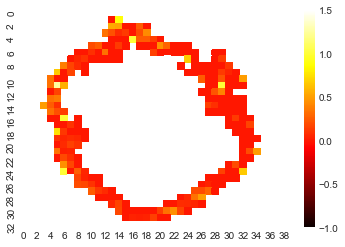

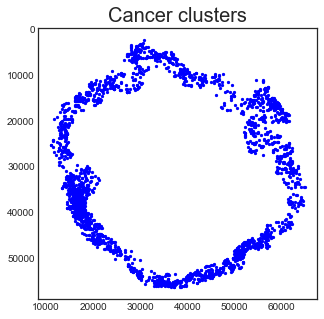

1it [00:48, 48.67s/it]

Code: 0691



100%|██████████| 37/37 [00:01<00:00, 31.85it/s]

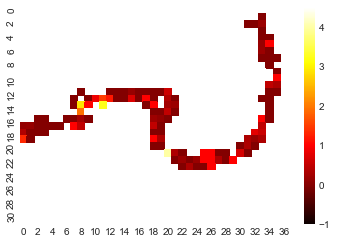

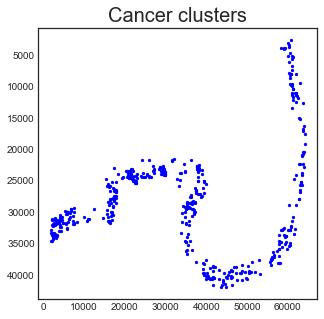

2it [01:14, 37.41s/it]

Code: 0692



100%|██████████| 37/37 [00:03<00:00, 10.36it/s]


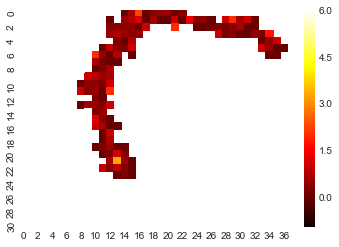

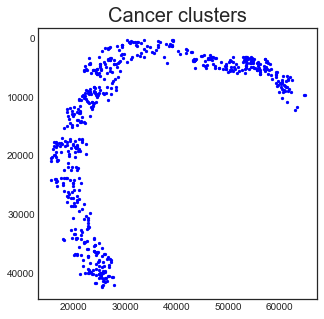

3it [01:49, 36.60s/it]

Code: 0693



100%|██████████| 48/48 [00:01<00:00, 25.94it/s]

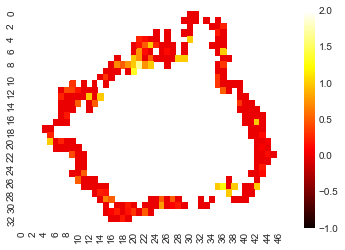

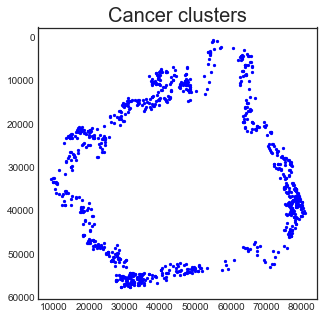

4it [02:22, 35.60s/it]

Code: 0694



100%|██████████| 47/47 [00:01<00:00, 36.90it/s]

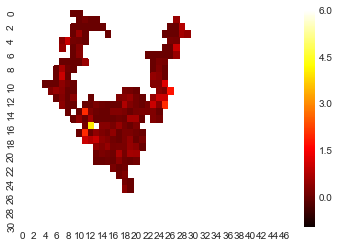

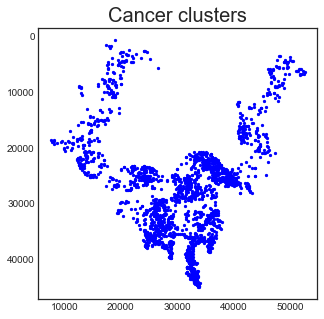

5it [02:59, 35.89s/it]

Code: 0695



100%|██████████| 38/38 [00:02<00:00, 15.48it/s]


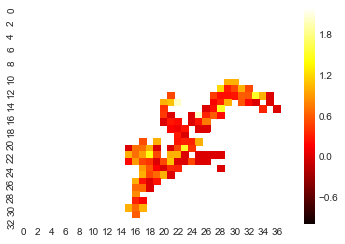

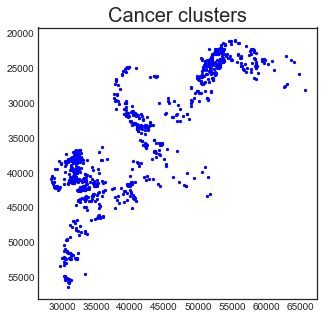

6it [03:35, 35.85s/it]

Code: 0696



100%|██████████| 40/40 [00:01<00:00, 25.14it/s]

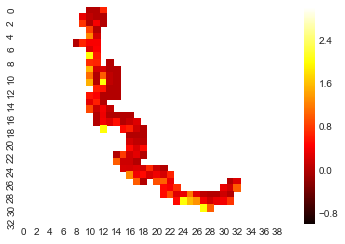

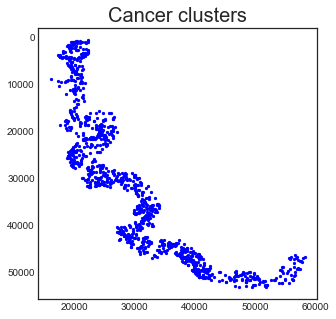

7it [04:05, 35.05s/it]

Code: 0697



100%|██████████| 41/41 [00:03<00:00, 11.98it/s]


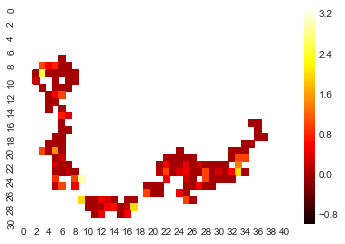

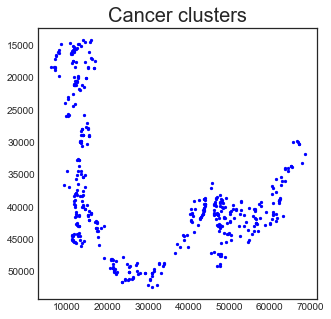

8it [04:47, 35.92s/it]

Code: 0698



100%|██████████| 43/43 [00:03<00:00, 11.00it/s]

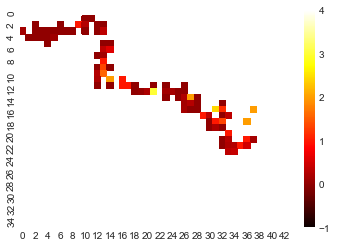

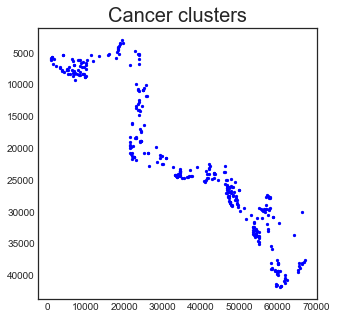

9it [05:27, 36.36s/it]

Code: 0699



100%|██████████| 38/38 [00:00<00:00, 47.79it/s]

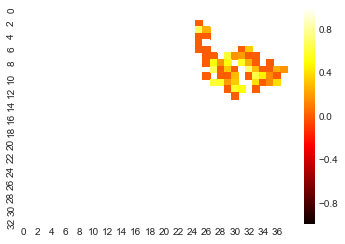

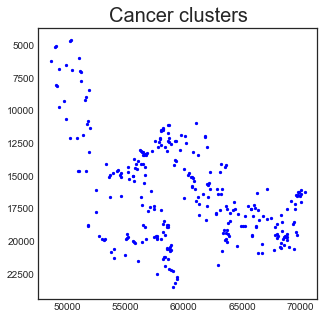

10it [05:40, 34.10s/it]

Code: 0700



100%|██████████| 45/45 [00:04<00:00,  9.64it/s]


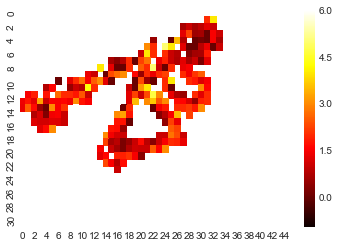

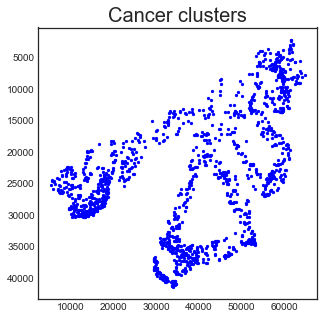

11it [06:27, 35.23s/it]

Code: 0701



100%|██████████| 24/24 [00:00<00:00, 68.20it/s]

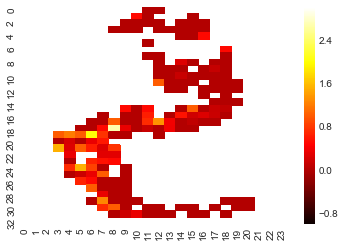

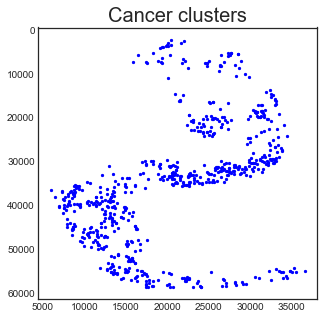

12it [06:44, 33.74s/it]

Code: 0702



100%|██████████| 38/38 [00:01<00:00, 29.37it/s]

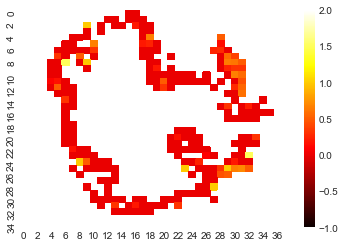

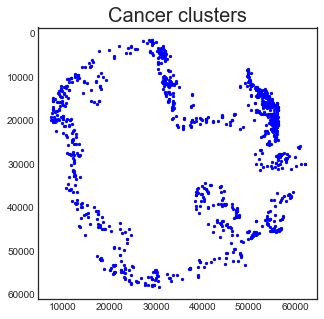

13it [07:24, 34.19s/it]

Code: 0703



100%|██████████| 40/40 [00:02<00:00, 15.10it/s]


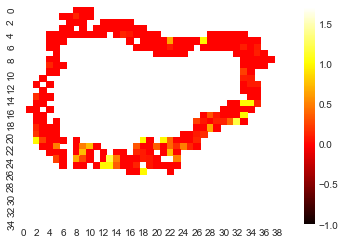

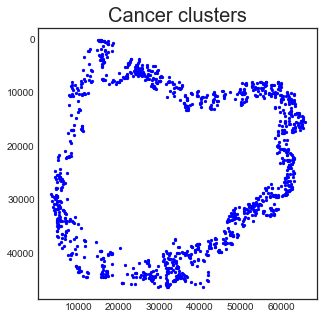

14it [07:57, 34.08s/it]

Code: 0704



100%|██████████| 42/42 [00:02<00:00, 18.61it/s]


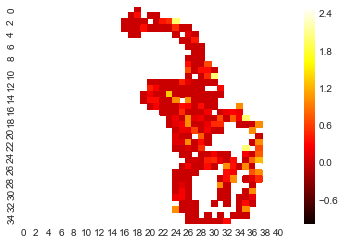

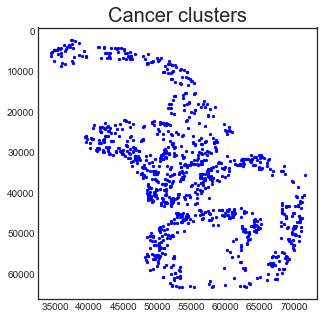

15it [08:42, 34.86s/it]

Code: 0706



100%|██████████| 46/46 [00:01<00:00, 30.05it/s]


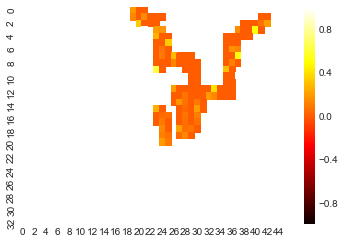

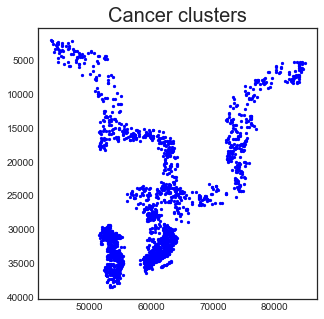

16it [09:22, 35.14s/it]

Code: 0707



100%|██████████| 43/43 [00:02<00:00, 15.92it/s]

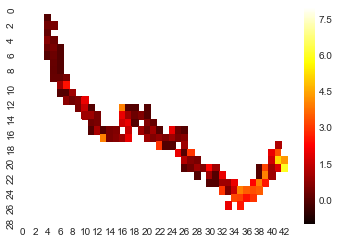

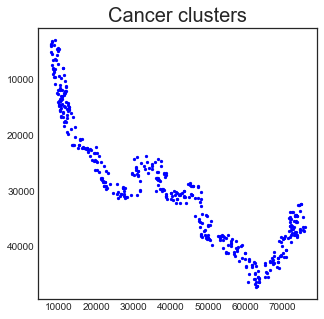

17it [09:51, 34.78s/it]

Code: 0708



100%|██████████| 39/39 [00:00<00:00, 39.78it/s]

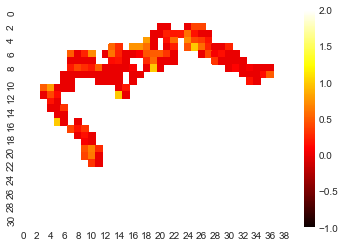

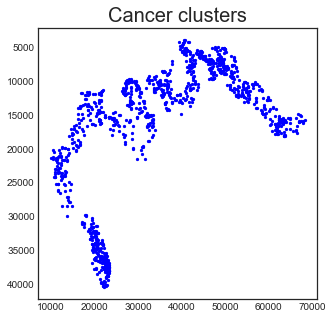

18it [10:21, 34.53s/it]

Code: 0709



100%|██████████| 41/41 [00:01<00:00, 28.13it/s]

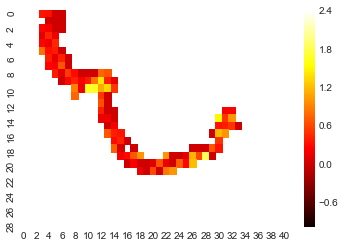

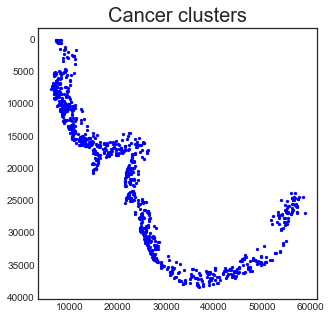

19it [10:47, 34.07s/it]

Code: 0710



100%|██████████| 29/29 [00:01<00:00, 23.96it/s]

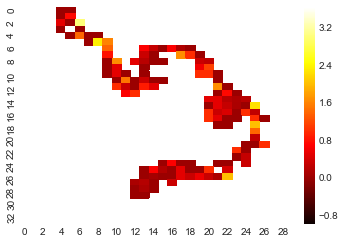

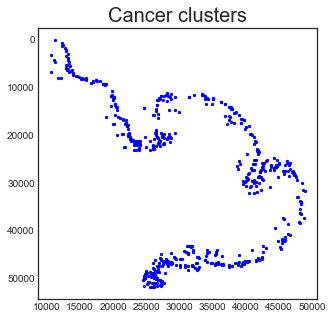

20it [11:09, 33.50s/it]

Code: 0711



100%|██████████| 43/43 [00:00<00:00, 78.45it/s]

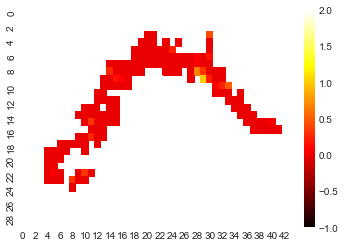

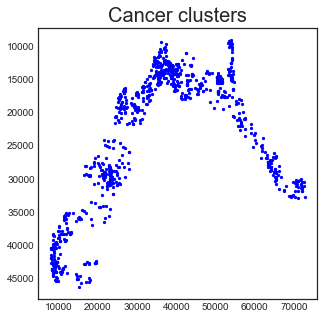

21it [11:33, 33.02s/it]

Code: 0712



100%|██████████| 38/38 [00:00<00:00, 225.10it/s]

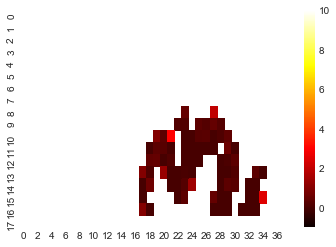

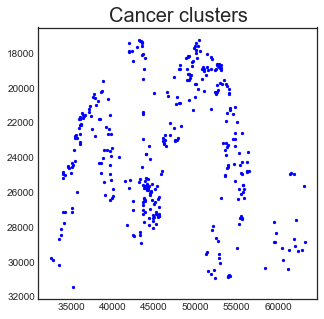

22it [11:42, 31.91s/it]

Code: 0713



100%|██████████| 40/40 [00:00<00:00, 87.83it/s]

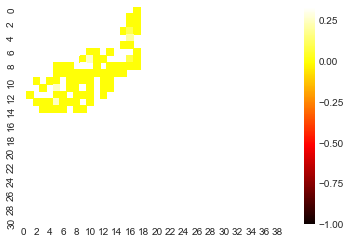

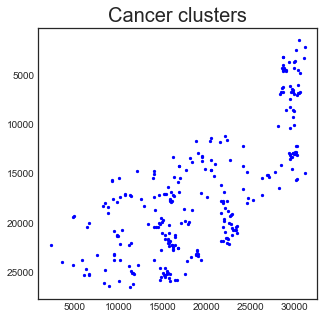

23it [11:59, 31.29s/it]

Code: 0714



100%|██████████| 32/32 [00:01<00:00, 16.24it/s]

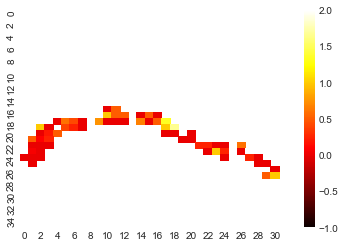

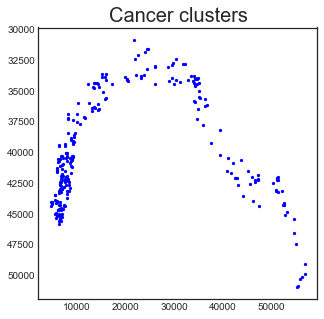

24it [12:21, 30.90s/it]

Code: 0715



100%|██████████| 44/44 [00:01<00:00, 22.84it/s]

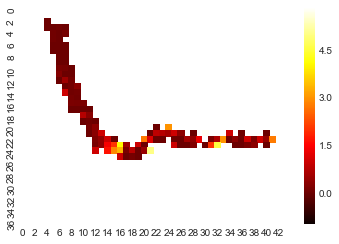

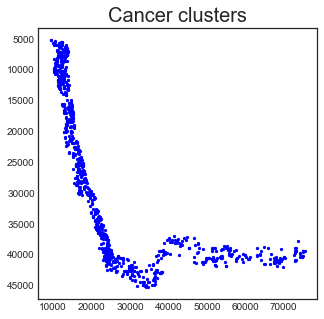

25it [13:00, 31.20s/it]

Code: 0716



100%|██████████| 38/38 [00:00<00:00, 61.78it/s]

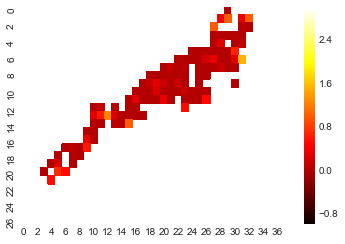

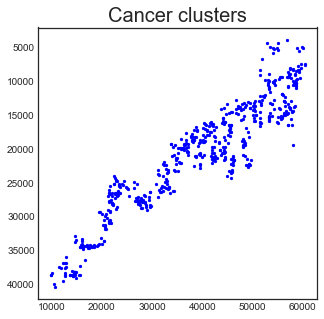

26it [13:16, 30.65s/it]

Code: 0717



100%|██████████| 42/42 [00:01<00:00, 23.67it/s]


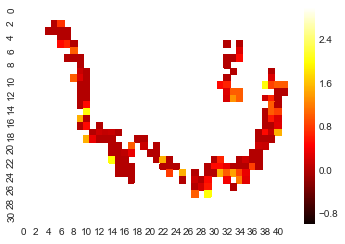

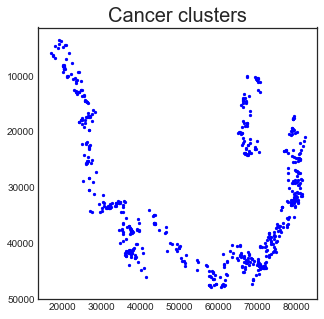

27it [13:42, 30.46s/it]

Code: 0719



100%|██████████| 45/45 [00:00<00:00, 133.54it/s]

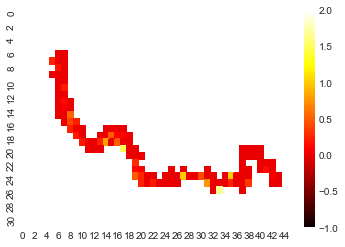

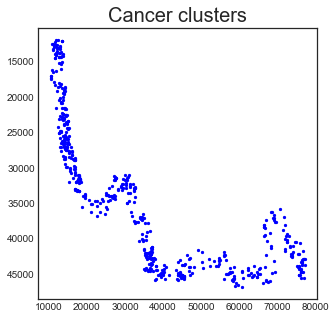

28it [13:55, 29.82s/it]

Code: 0720



100%|██████████| 37/37 [00:01<00:00, 19.25it/s]

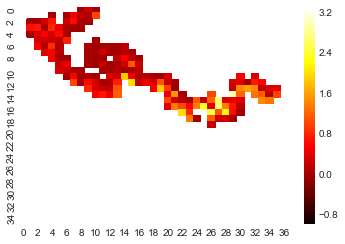

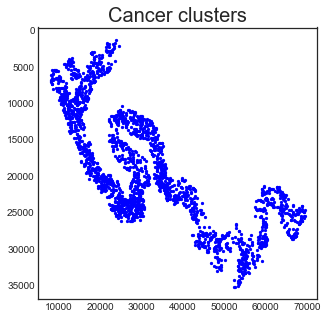

29it [14:30, 30.01s/it]

Code: 0721



100%|██████████| 45/45 [00:01<00:00, 35.65it/s]

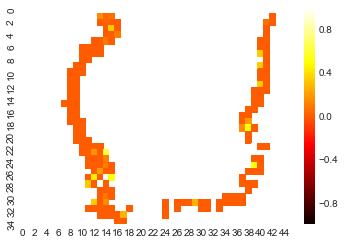

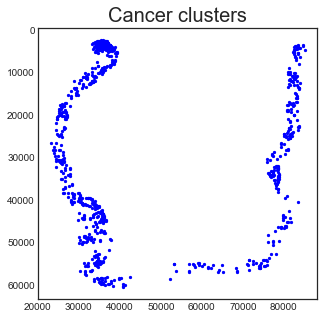

30it [15:00, 30.01s/it]

Code: 0722



100%|██████████| 39/39 [00:01<00:00, 21.53it/s]

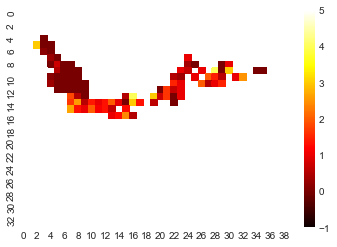

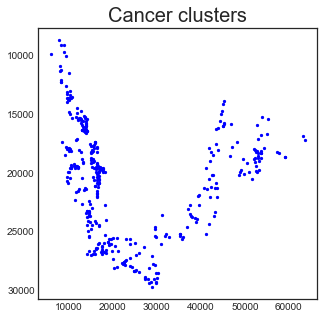

31it [15:21, 29.73s/it]

Code: 0723



100%|██████████| 39/39 [00:00<00:00, 74.88it/s]


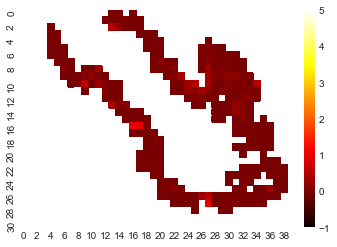

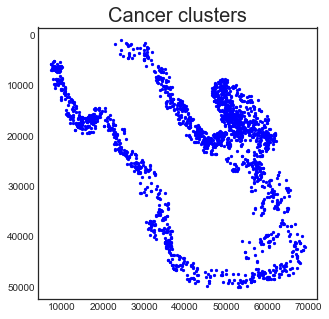

32it [15:50, 29.70s/it]

Code: 0724



100%|██████████| 42/42 [00:03<00:00, 12.24it/s]

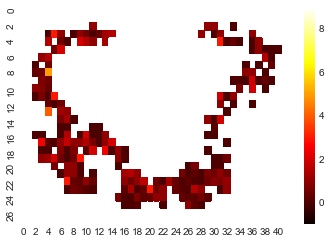

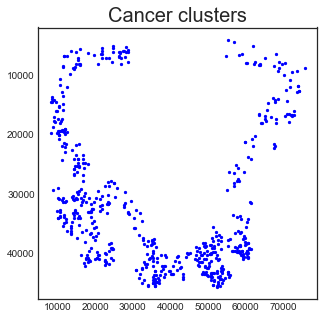

33it [16:26, 29.88s/it]

Code: 0725



100%|██████████| 48/48 [00:02<00:00, 21.34it/s]


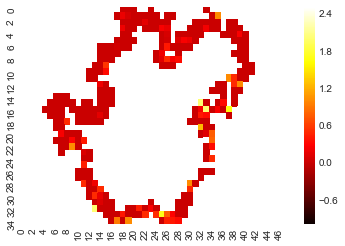

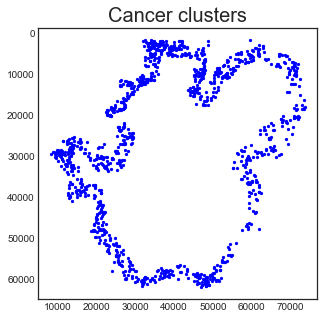

34it [17:06, 30.20s/it]

Code: 0727



100%|██████████| 37/37 [00:02<00:00, 14.69it/s]

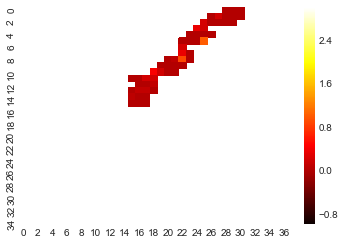

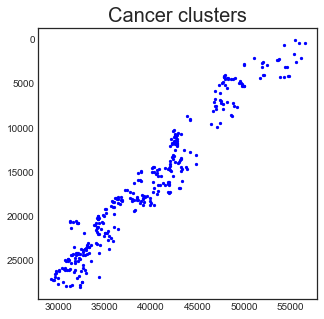

35it [17:35, 30.16s/it]

Code: 0728



100%|██████████| 38/38 [00:00<00:00, 53.96it/s]

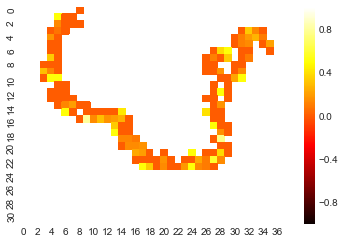

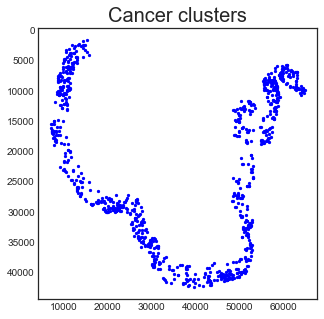

36it [17:57, 29.93s/it]

Code: 0729



100%|██████████| 42/42 [00:00<00:00, 48.26it/s]


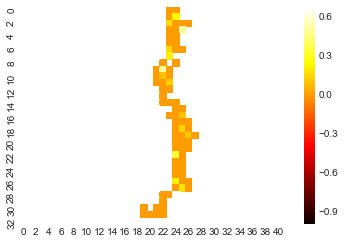

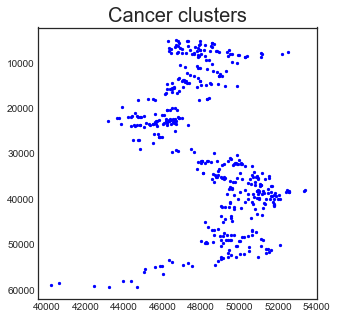

37it [18:23, 29.82s/it]

Code: 0730



100%|██████████| 45/45 [00:01<00:00, 25.76it/s]

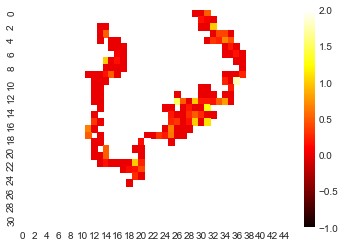

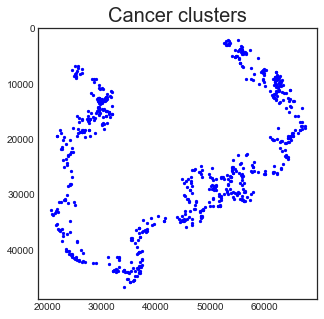

38it [18:48, 29.71s/it]

Code: 0731



100%|██████████| 49/49 [00:01<00:00, 41.29it/s]

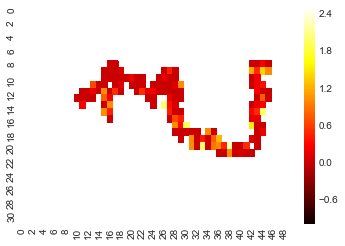

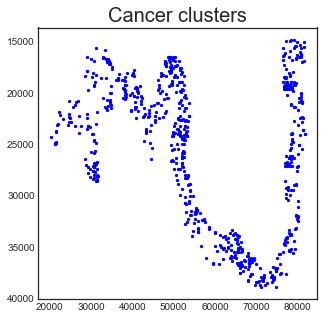

39it [19:16, 29.66s/it]

Code: 0732



100%|██████████| 47/47 [00:01<00:00, 40.72it/s]


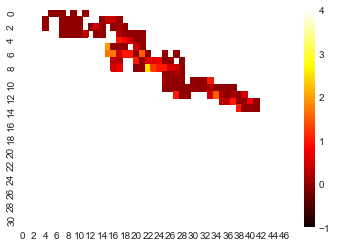

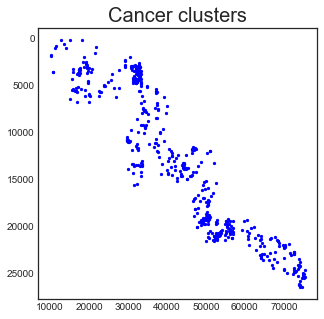

40it [19:36, 29.42s/it]

Code: 0733



100%|██████████| 46/46 [00:02<00:00, 17.89it/s]

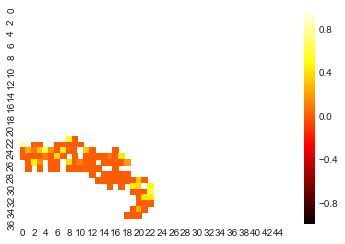

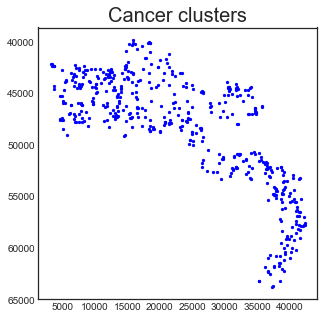

41it [20:03, 29.34s/it]

Code: 0734



100%|██████████| 42/42 [00:02<00:00, 15.77it/s]


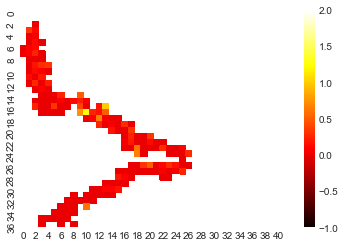

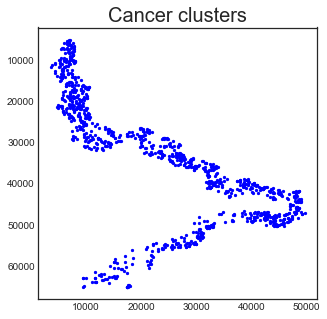

42it [20:43, 29.60s/it]

Code: 0735



100%|██████████| 46/46 [00:01<00:00, 28.46it/s]

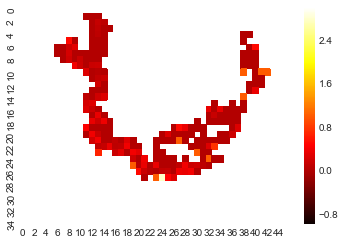

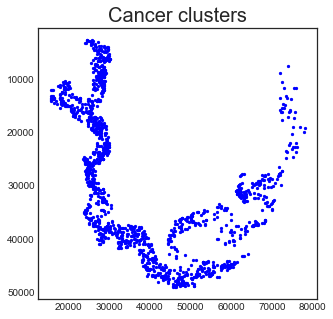

43it [21:15, 29.66s/it]

Code: 0736



100%|██████████| 31/31 [00:00<00:00, 218.58it/s]

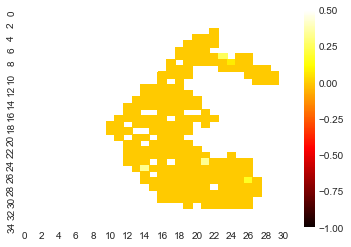

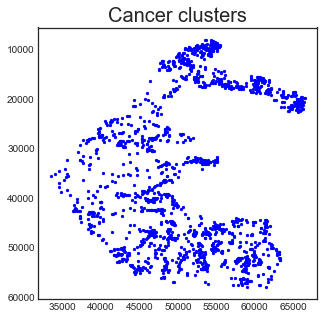

44it [21:33, 29.41s/it]

Code: 0737



100%|██████████| 38/38 [00:00<00:00, 44.27it/s]

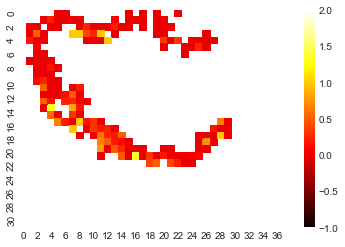

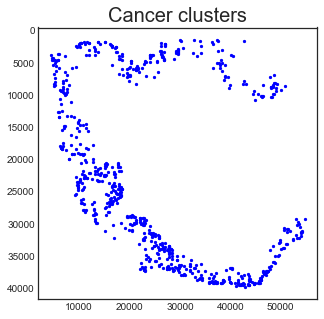

45it [21:54, 29.20s/it]

Code: 0738



100%|██████████| 30/30 [00:00<00:00, 95.77it/s]


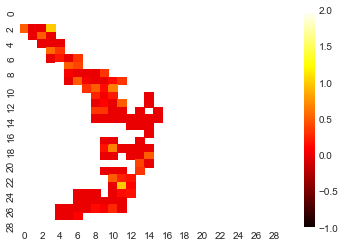

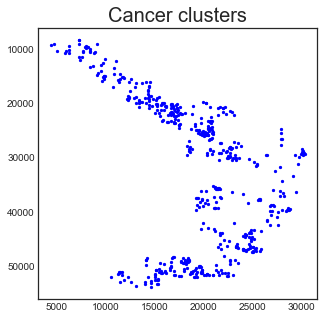

46it [22:08, 28.87s/it]

Code: 0739



100%|██████████| 41/41 [00:00<00:00, 73.93it/s]


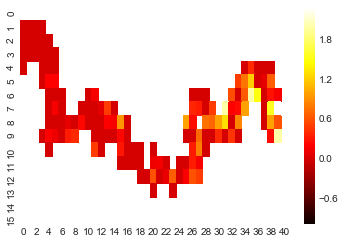

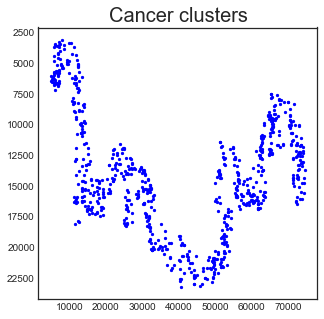

47it [22:32, 28.77s/it]

Code: 0740



100%|██████████| 36/36 [00:01<00:00, 22.21it/s]

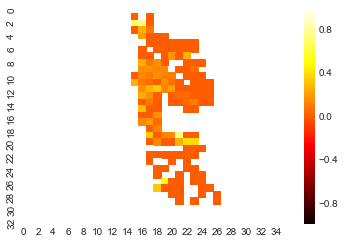

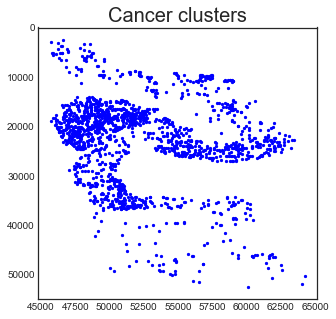

48it [23:25, 29.28s/it]

Code: 0741



100%|██████████| 48/48 [00:05<00:00,  9.40it/s]


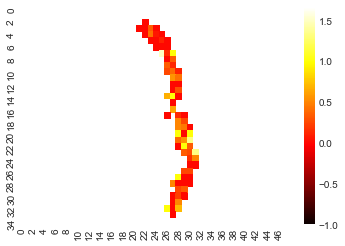

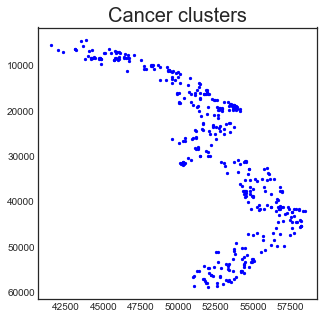

49it [24:20, 29.81s/it]

Code: 0742



100%|██████████| 40/40 [00:01<00:00, 28.00it/s]

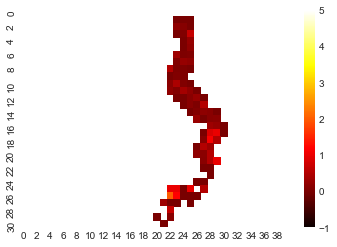

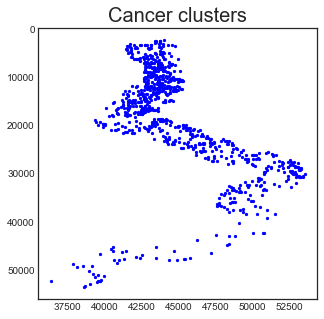

50it [24:54, 29.88s/it]

Code: 0744



100%|██████████| 34/34 [00:00<00:00, 156.16it/s]

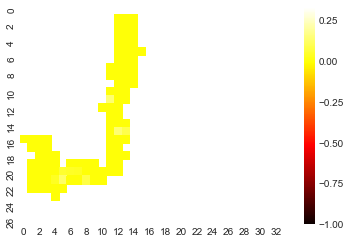

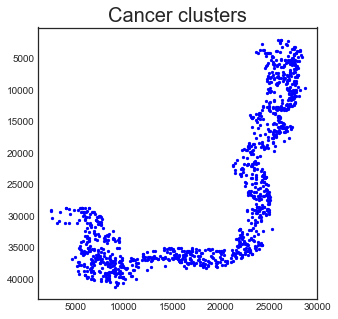

51it [25:09, 29.60s/it]

Code: 0745



100%|██████████| 28/28 [00:00<00:00, 154.43it/s]

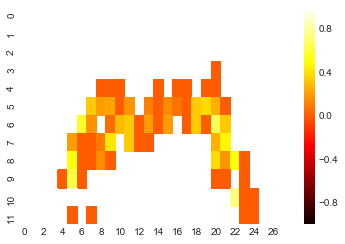

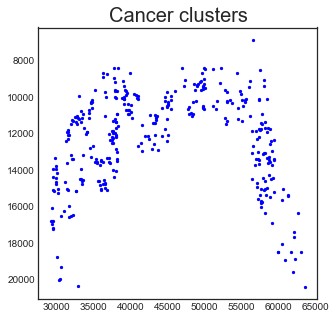

52it [25:16, 29.16s/it]

Code: 0746



100%|██████████| 47/47 [00:01<00:00, 31.55it/s]


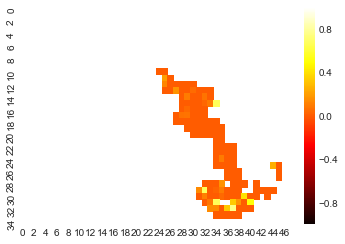

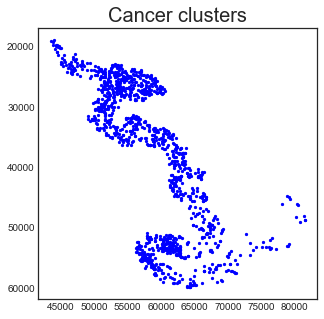

53it [25:51, 29.27s/it]

Code: 0747



100%|██████████| 47/47 [00:02<00:00, 20.88it/s]


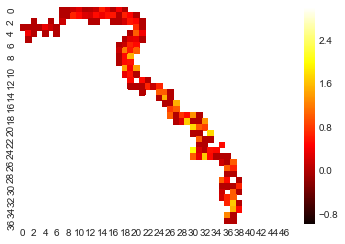

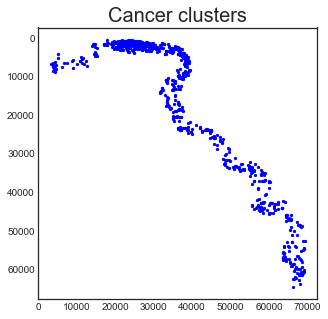

54it [26:32, 29.50s/it]

Code: 0748



100%|██████████| 42/42 [00:01<00:00, 35.04it/s]

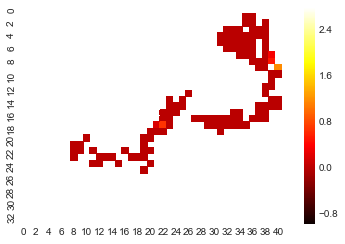

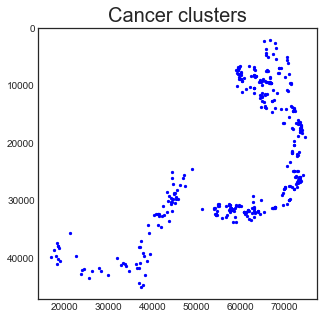

55it [26:58, 29.43s/it]

Code: 0749



100%|██████████| 29/29 [00:00<00:00, 44.44it/s]

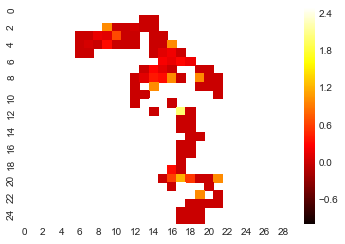

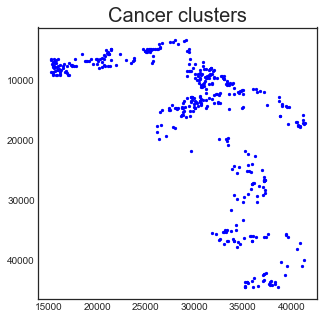

56it [27:11, 29.14s/it]

Code: 0750



100%|██████████| 38/38 [00:01<00:00, 33.53it/s]

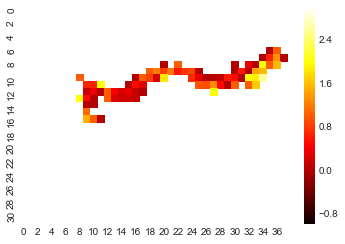

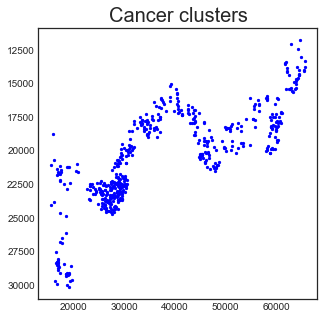

57it [27:30, 28.95s/it]

Code: 0751



100%|██████████| 29/29 [00:01<00:00, 20.74it/s]

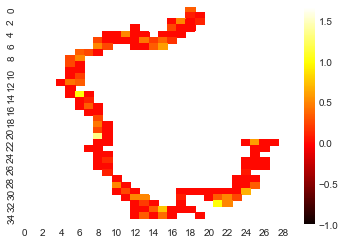

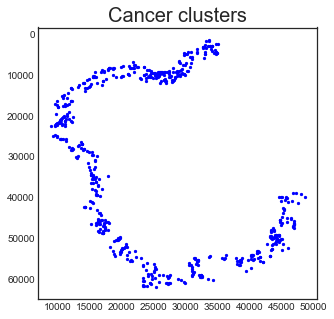

58it [27:52, 28.84s/it]

Code: 0752



100%|██████████| 31/31 [00:00<00:00, 45.26it/s]

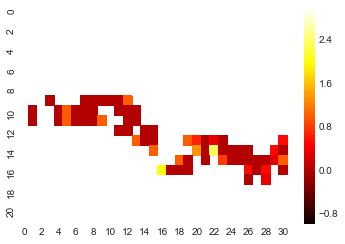

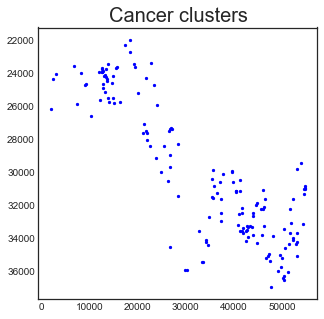

59it [28:03, 28.54s/it]

Code: 0753



100%|██████████| 47/47 [00:00<00:00, 47.07it/s]


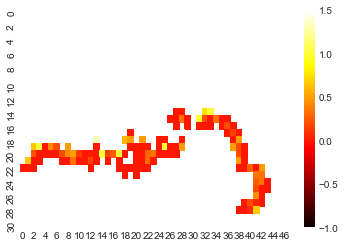

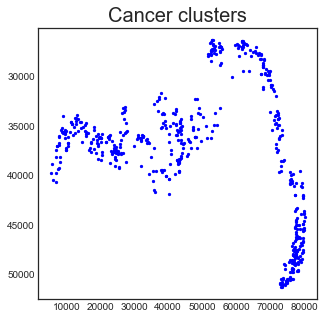

60it [28:22, 28.38s/it]

Code: 0754



100%|██████████| 40/40 [00:01<00:00, 28.57it/s]

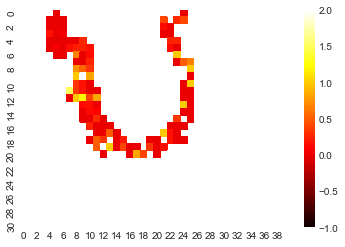

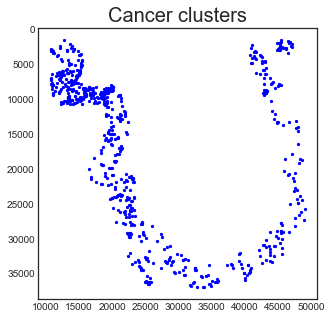

61it [28:52, 28.40s/it]

Code: 0755



100%|██████████| 49/49 [00:02<00:00, 17.51it/s]


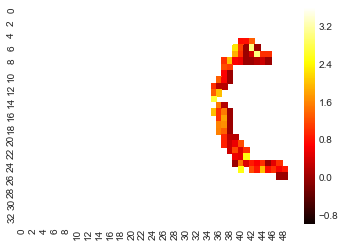

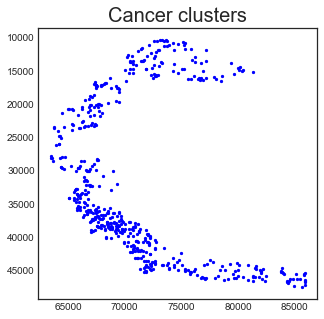

62it [29:29, 28.54s/it]

Code: 0757



100%|██████████| 34/34 [00:00<00:00, 34.39it/s]

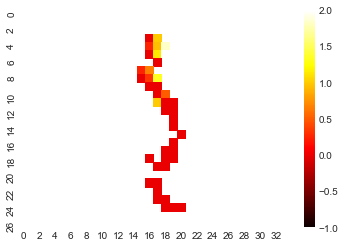

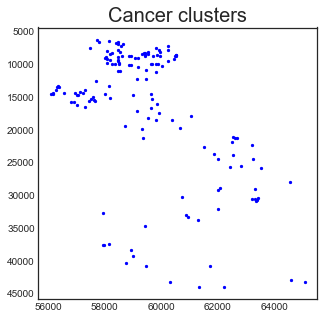

63it [29:43, 28.30s/it]

Code: 0758



100%|██████████| 40/40 [00:02<00:00, 19.76it/s]

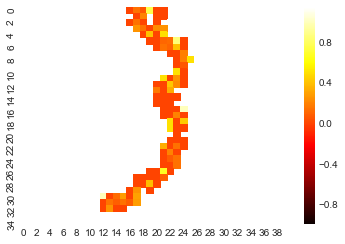

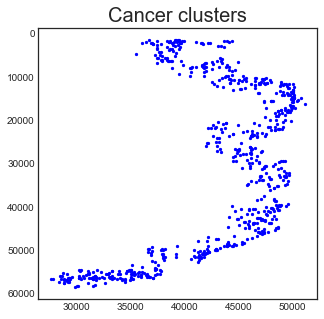

64it [30:18, 28.41s/it]

Code: 0759



100%|██████████| 39/39 [00:01<00:00, 38.43it/s]

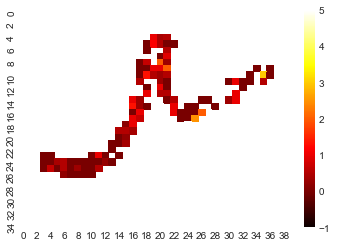

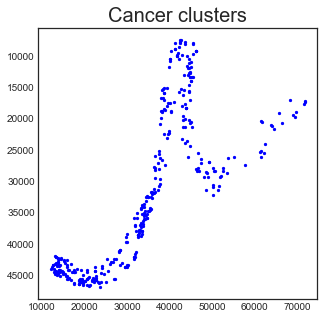

65it [30:40, 28.31s/it]

Code: 0760



100%|██████████| 41/41 [00:01<00:00, 27.70it/s]

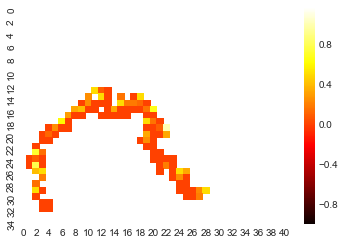

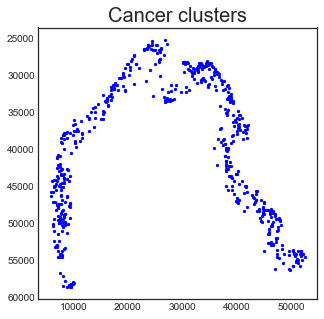

66it [31:10, 28.34s/it]

Code: 0761



100%|██████████| 42/42 [00:01<00:00, 26.92it/s]

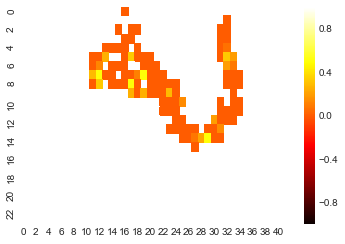

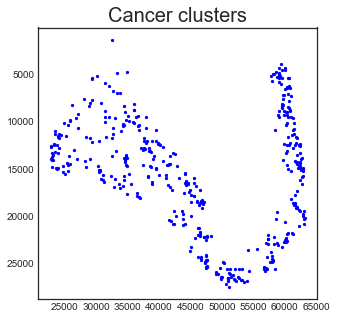

67it [31:31, 28.23s/it]

Code: 0762



100%|██████████| 35/35 [00:00<00:00, 43.86it/s]

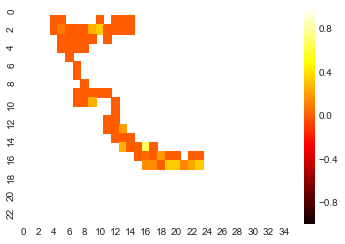

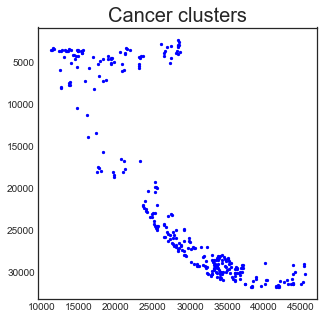

68it [31:47, 28.05s/it]

Code: 0763



100%|██████████| 45/45 [00:05<00:00,  7.93it/s]

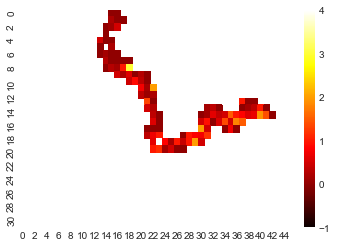

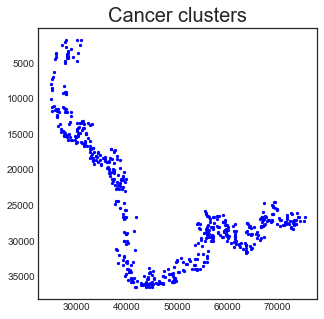

69it [32:30, 28.26s/it]

Code: 0764



100%|██████████| 41/41 [00:02<00:00, 17.86it/s]


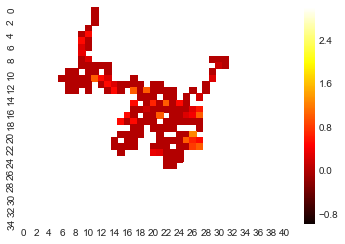

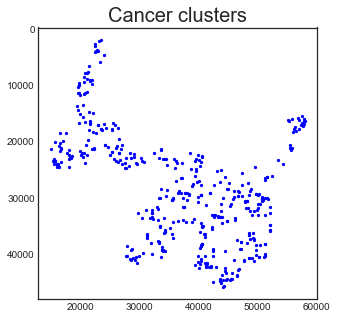

70it [32:59, 28.28s/it]

Code: 0765



100%|██████████| 40/40 [00:01<00:00, 34.49it/s]


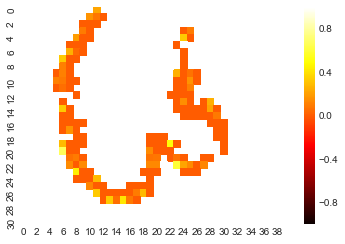

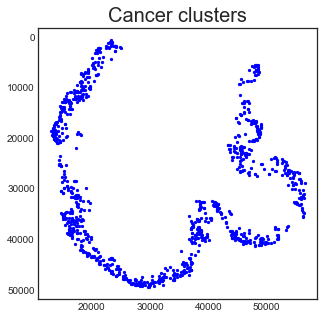

71it [33:30, 28.32s/it]

Code: 0767



100%|██████████| 45/45 [00:01<00:00, 28.31it/s]


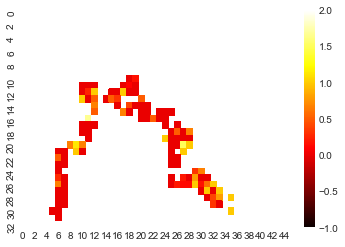

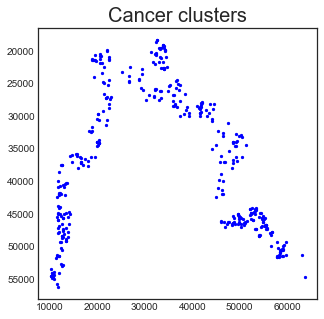

72it [33:59, 28.33s/it]

Code: 0768



100%|██████████| 41/41 [00:02<00:00, 17.76it/s]


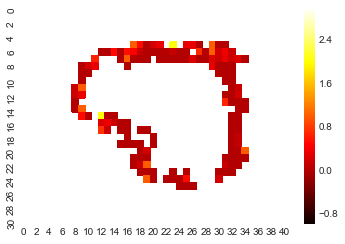

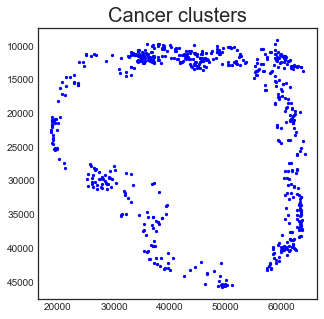

73it [34:28, 28.33s/it]

Code: 0769



100%|██████████| 46/46 [00:01<00:00, 29.08it/s]

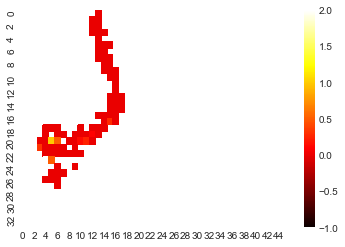

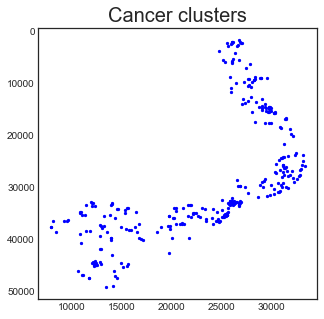

74it [34:56, 28.33s/it]

Code: 0770



100%|██████████| 41/41 [00:01<00:00, 28.26it/s]

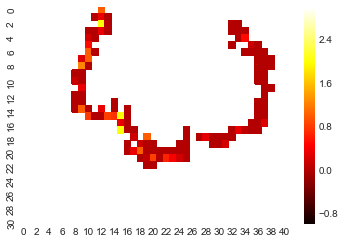

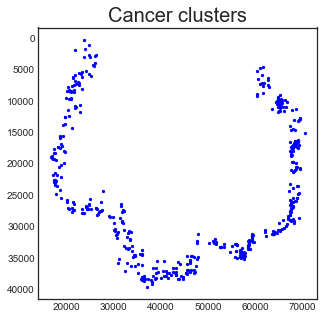

75it [35:17, 28.23s/it]

Code: 0772



100%|██████████| 39/39 [00:01<00:00, 36.50it/s]

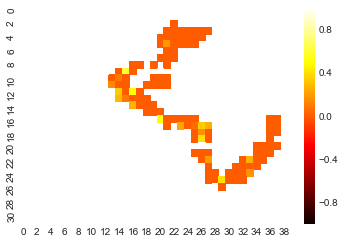

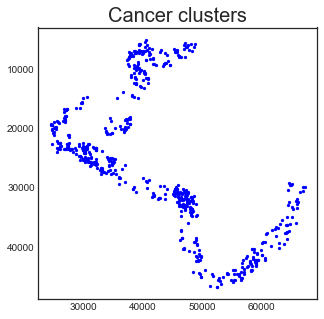

76it [35:38, 28.14s/it]

Code: 0774



100%|██████████| 35/35 [00:01<00:00, 33.40it/s]


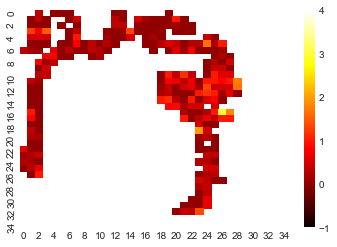

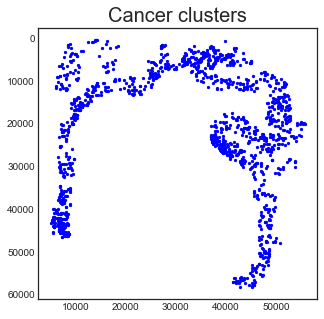

77it [36:05, 28.12s/it]

Code: 0775



100%|██████████| 39/39 [00:02<00:00, 15.67it/s]

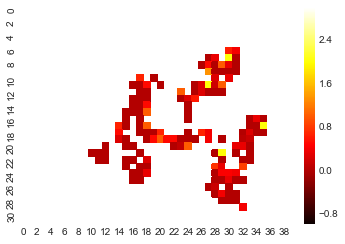

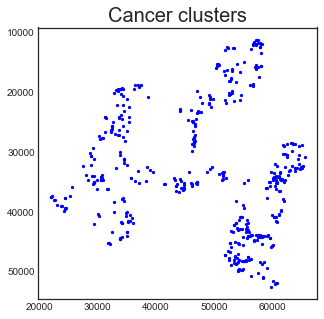

78it [36:31, 28.10s/it]

Code: 0776



100%|██████████| 44/44 [00:01<00:00, 31.76it/s]

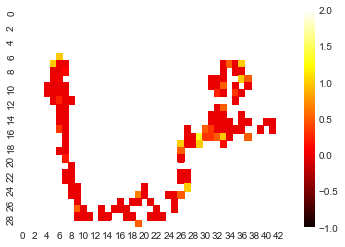

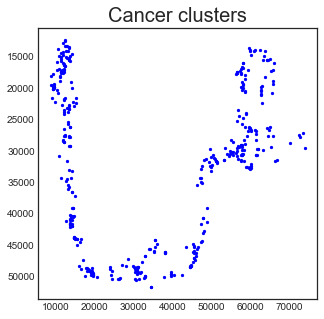

79it [36:57, 28.07s/it]

Code: 0777



100%|██████████| 42/42 [00:00<00:00, 82.79it/s]

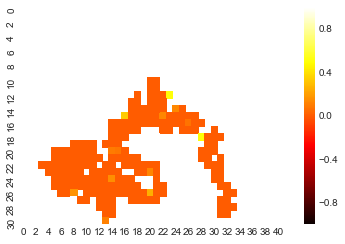

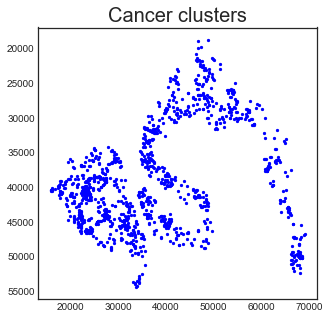

80it [37:28, 28.11s/it]

Code: 0778



100%|██████████| 41/41 [00:02<00:00, 20.20it/s]

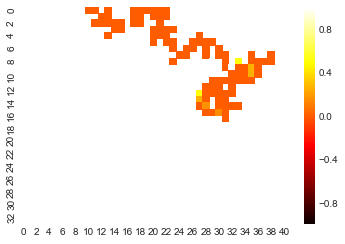

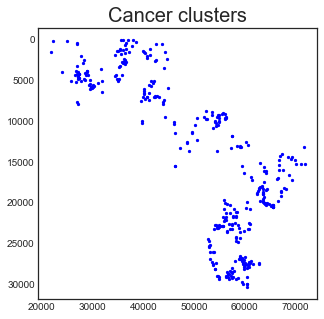

81it [37:53, 28.07s/it]

Code: 0779



100%|██████████| 41/41 [00:00<00:00, 57.14it/s]

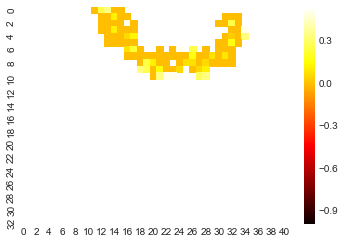

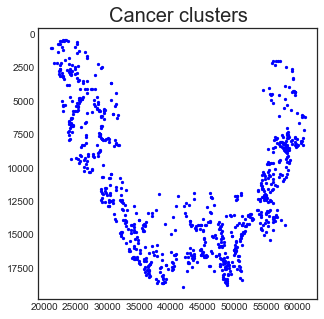

82it [38:10, 27.93s/it]

Code: 0780



100%|██████████| 36/36 [00:02<00:00, 17.30it/s]

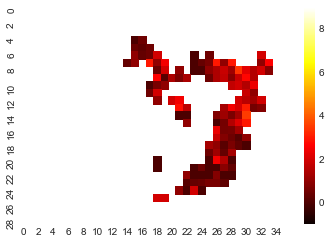

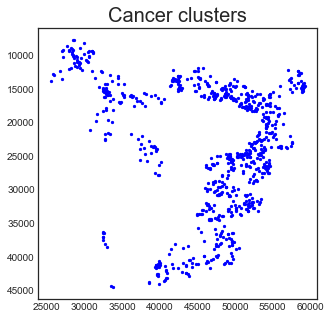

83it [38:45, 28.02s/it]

Code: 0781



100%|██████████| 40/40 [00:01<00:00, 37.99it/s]

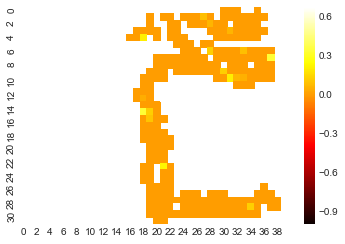

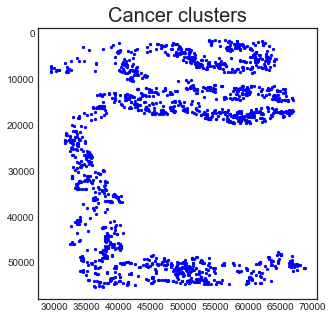

84it [39:17, 28.06s/it]

Code: 0782



100%|██████████| 34/34 [00:00<00:00, 82.44it/s]

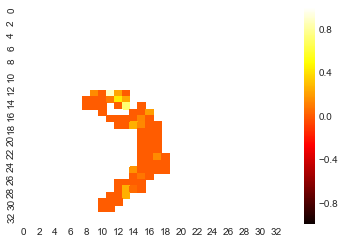

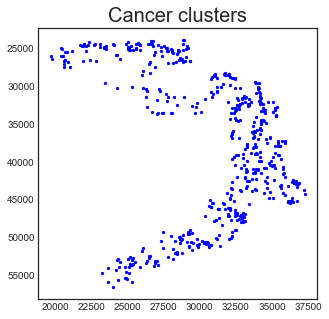

85it [39:30, 27.88s/it]

Code: 0783



100%|██████████| 43/43 [00:01<00:00, 40.81it/s]

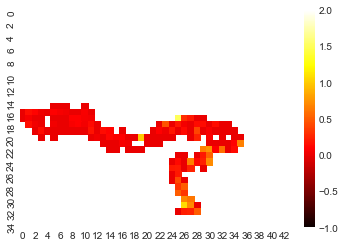

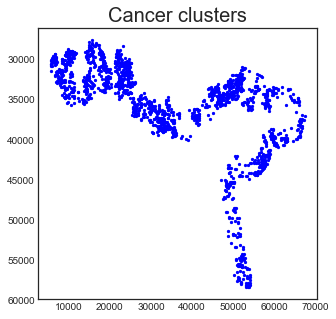

86it [40:03, 27.95s/it]

Code: 0784



100%|██████████| 49/49 [00:02<00:00, 23.37it/s]

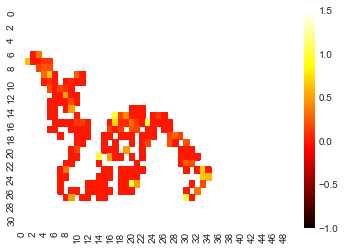

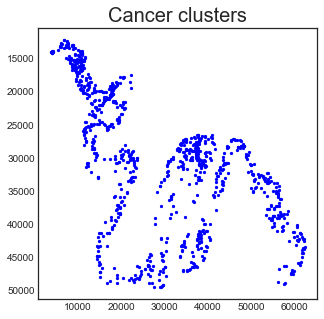

87it [40:32, 27.96s/it]

Code: 0785



100%|██████████| 47/47 [00:01<00:00, 28.06it/s]

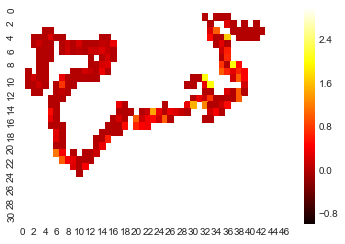

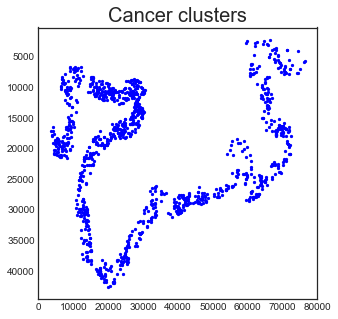

88it [41:03, 28.00s/it]

Code: 0786



100%|██████████| 38/38 [00:02<00:00, 13.33it/s]


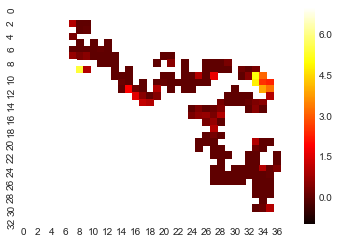

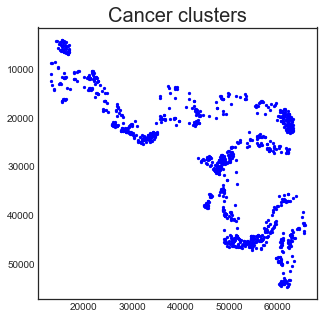

89it [41:42, 28.12s/it]

Code: 0787



100%|██████████| 39/39 [00:01<00:00, 22.22it/s]

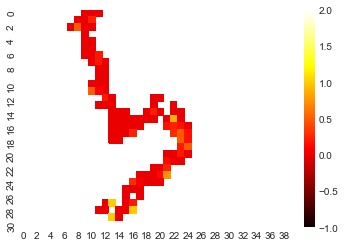

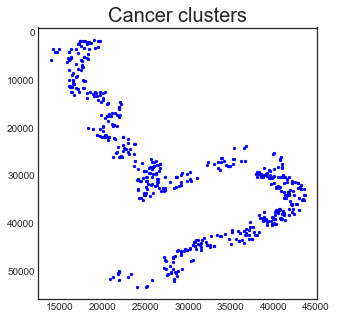

90it [42:09, 28.11s/it]

Code: 0788



100%|██████████| 15/15 [00:00<00:00, 61.05it/s]

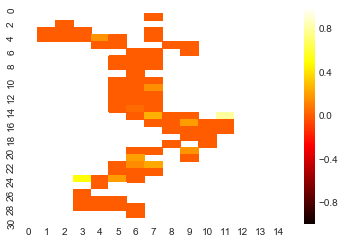

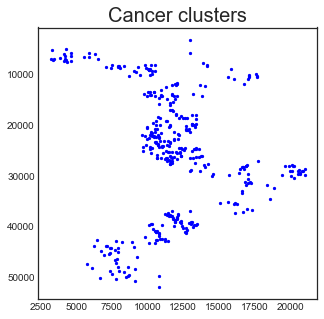

91it [42:19, 27.91s/it]

Code: 0790



100%|██████████| 29/29 [00:01<00:00, 21.28it/s]

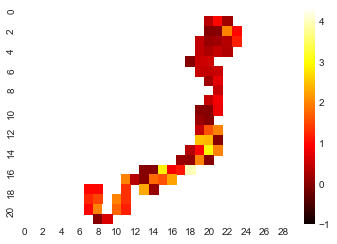

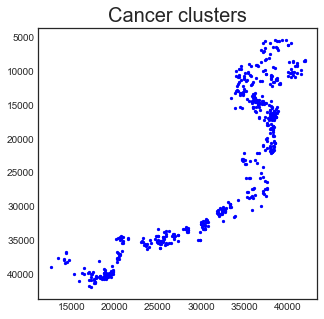

92it [42:38, 27.81s/it]

Code: 0791



100%|██████████| 29/29 [00:00<00:00, 77.57it/s]

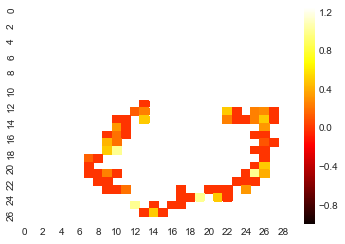

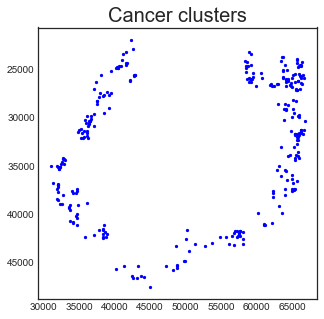

93it [42:49, 27.63s/it]

Code: 0792



100%|██████████| 35/35 [00:00<00:00, 49.15it/s]

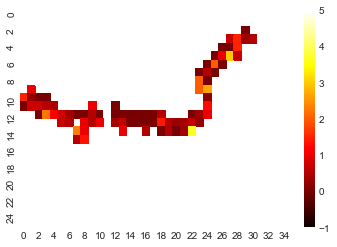

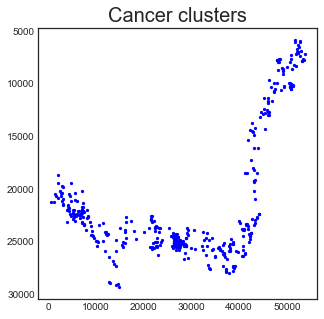

94it [43:04, 27.50s/it]

Code: 0793



100%|██████████| 40/40 [00:00<00:00, 81.63it/s]

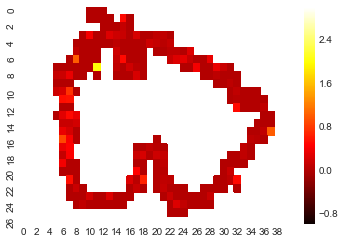

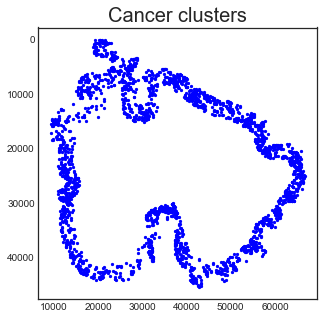

95it [43:33, 27.51s/it]

Code: 0795



100%|██████████| 40/40 [00:02<00:00, 15.13it/s]


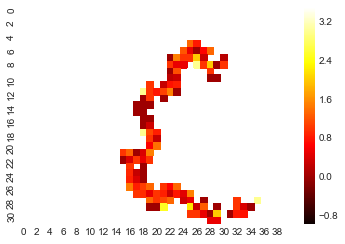

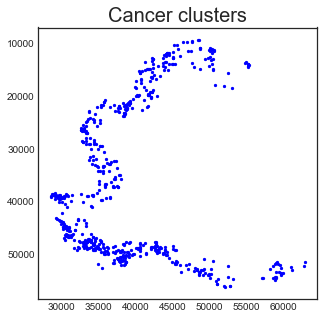

96it [44:01, 27.52s/it]

Code: 0796



100%|██████████| 37/37 [00:01<00:00, 27.26it/s]

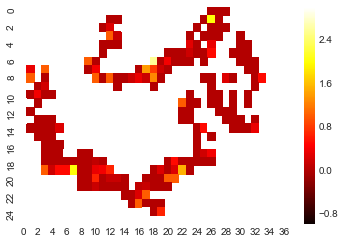

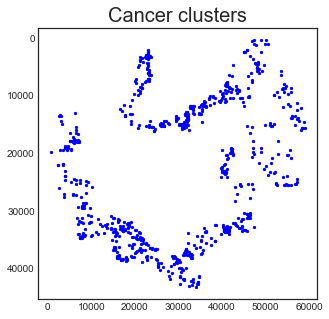

97it [44:24, 27.46s/it]

Code: 0797



100%|██████████| 37/37 [00:01<00:00, 19.98it/s]

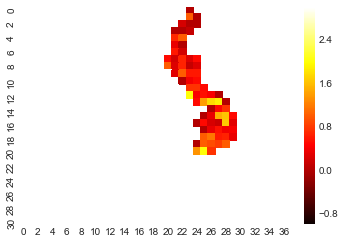

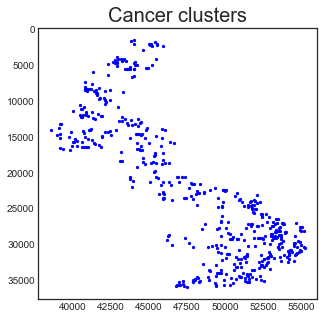

98it [44:49, 27.45s/it]

Code: 0798



100%|██████████| 28/28 [00:00<00:00, 38.48it/s]

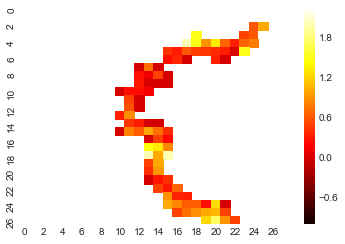

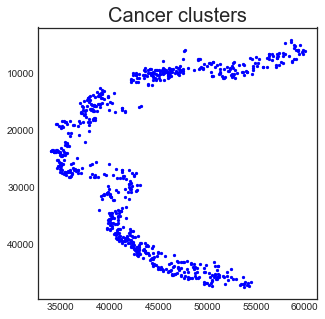

99it [45:07, 27.35s/it]

Code: 0799



100%|██████████| 34/34 [00:01<00:00, 31.70it/s]

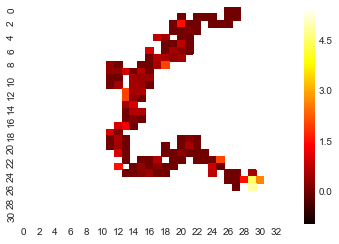

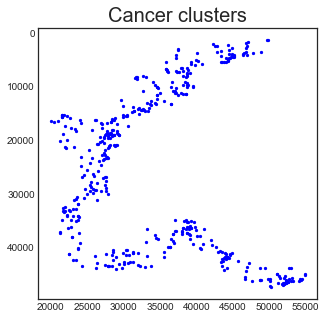

100it [45:28, 27.28s/it]

Code: 0800



100%|██████████| 32/32 [00:01<00:00, 29.21it/s]

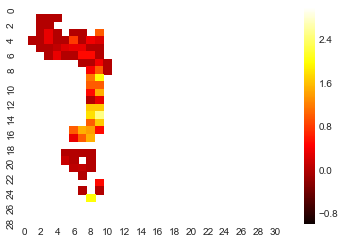

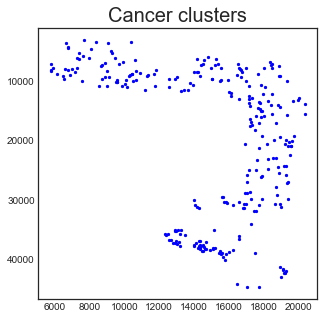

101it [45:41, 27.14s/it]

Code: 0801



100%|██████████| 38/38 [00:03<00:00, 11.61it/s]


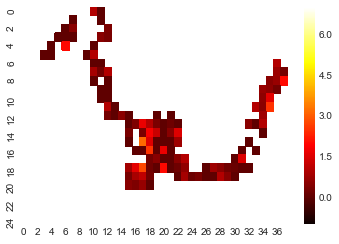

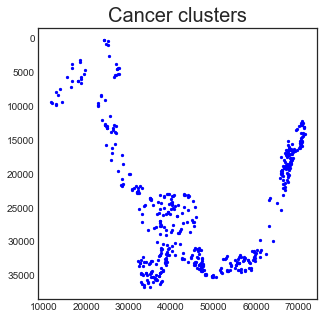

102it [46:23, 27.29s/it]

Code: 0803



100%|██████████| 21/21 [00:00<00:00, 30.94it/s]

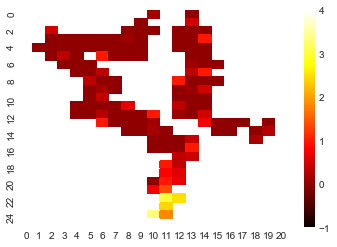

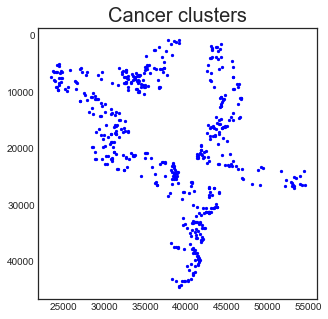

103it [46:38, 27.17s/it]

Code: 0804



100%|██████████| 37/37 [00:00<00:00, 58.10it/s]

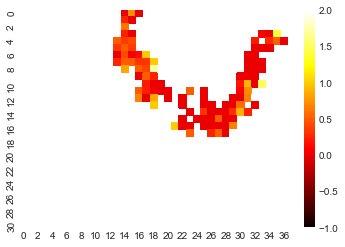

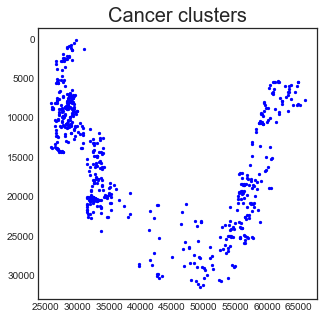

104it [46:53, 27.06s/it]

Code: 0805



100%|██████████| 39/39 [00:01<00:00, 26.94it/s]

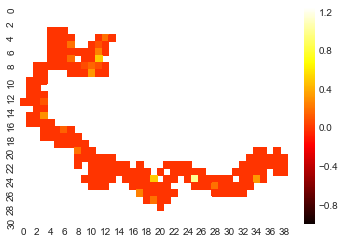

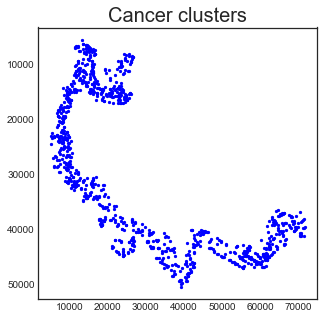

105it [47:22, 27.07s/it]

Code: 3300



100%|██████████| 41/41 [00:00<00:00, 148.31it/s]

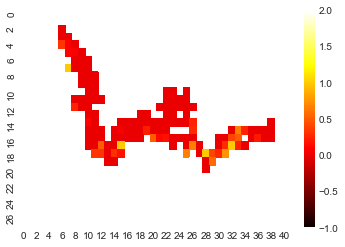

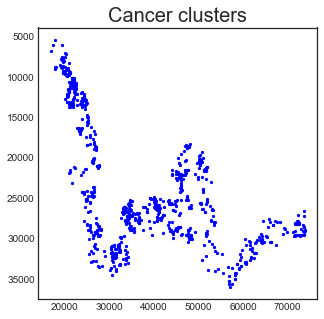

106it [47:37, 26.96s/it]

Code: 3301



100%|██████████| 52/52 [00:00<00:00, 125.43it/s]

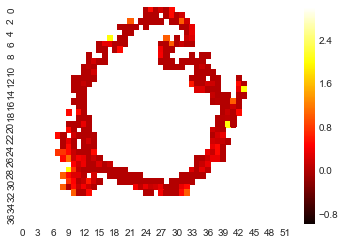

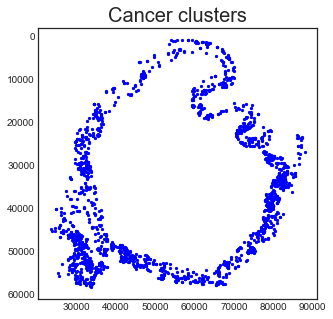

107it [48:11, 27.03s/it]

Code: 3302



100%|██████████| 32/32 [00:00<00:00, 46.35it/s]

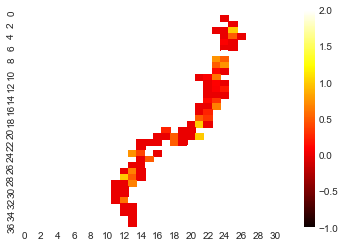

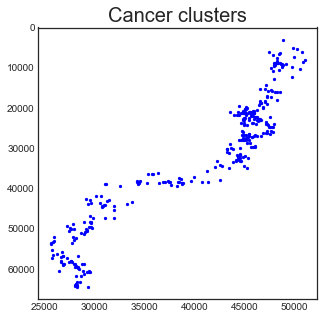

108it [48:33, 26.98s/it]

Code: 3303



100%|██████████| 32/32 [00:00<00:00, 318.94it/s]

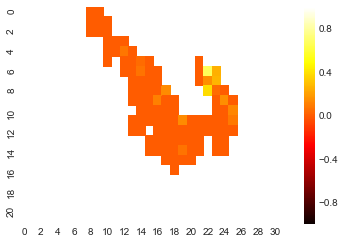

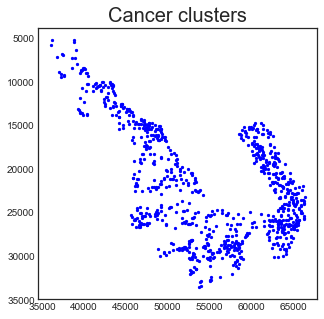

109it [48:44, 26.83s/it]

Code: 3304



100%|██████████| 49/49 [00:00<00:00, 52.41it/s]

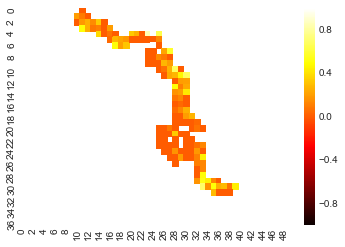

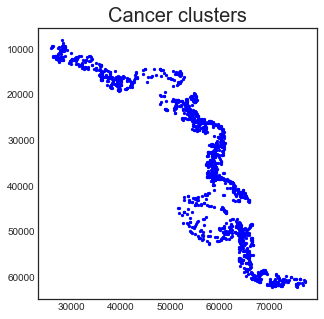

110it [49:16, 26.88s/it]

Code: 3305



100%|██████████| 58/58 [00:02<00:00, 23.43it/s]

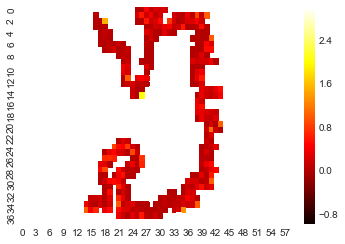

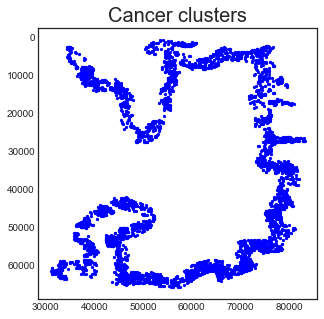

111it [50:43, 27.42s/it]

Code: 3307



100%|██████████| 33/33 [00:00<00:00, 145.93it/s]

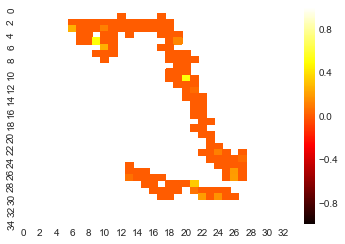

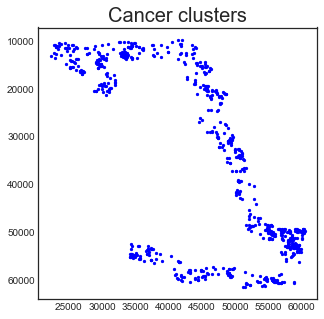

112it [50:59, 27.32s/it]

Code: 3308



100%|██████████| 46/46 [00:01<00:00, 35.87it/s]

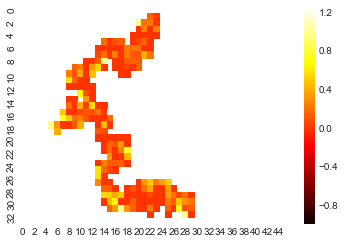

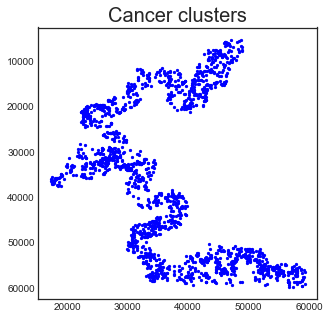

113it [51:37, 27.41s/it]

Code: ['SN16.czi_3042_job2807.object_results']



100%|██████████| 50/50 [00:02<00:00, 20.68it/s]


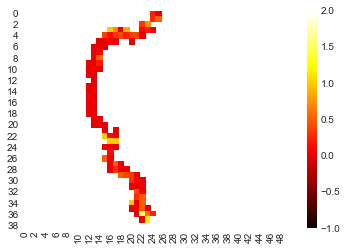

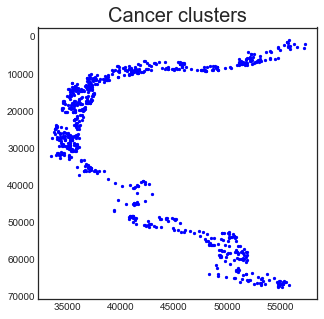

114it [52:13, 27.49s/it]

Code: ['SN20.czi_3043_job2808.object_results']



100%|██████████| 47/47 [00:03<00:00, 15.31it/s]

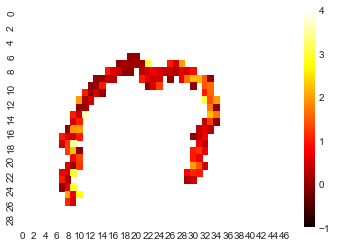

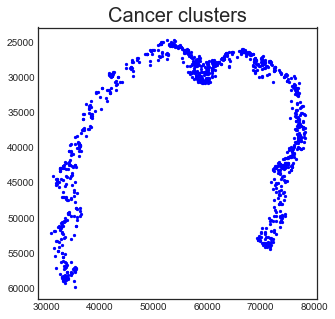

115it [52:48, 27.56s/it]


In [14]:
m = 115
d = 50
t = 1772

# Get ratios of lymphocytes near tumour buds over tumour buds, with 'near' being within 50 um of a bud
# using Euclidean distance. The length of each tile in the heatmap, t, in the heatmap is 886 um.
raw_images, outcomes, t, d, cluster_range = Loader.get_heatmaps(m=m, d=d, t=t, display_plot=True, pretty_print=False,
                                                                take_lymphocyte_ratio=False,
                                                                take_cd8_ratio=True)

In [ ]:
# Descriptive statistics
# -- Want to understand the characteristics of our dataset prior to trying out models.
# -- Prior knowledge is that small 'buds' of cancer cells (i.e. clusters with 1-4 cells) are significant in
#    the biological process. 
# -- Likewise, samples in our dataset vary considerably in size. This could be quite misleading for our model, 
#    so we will have each input sum to 1. We can also normalise these scaled features.
# -- Have various features like our heatmaps of lymphocytes against cancer clusters, sizes of clusters,
#    mean values and combinations. Also have CD3 and CD8 ratios individually as well. So need to explore a good
#    amount of data that come in different shapes and sizes.

m = 115
step = 1
upper = 21

raw_cluster_sizes, _, _, cluster_features_names, _ = Loader.load_cluster_size_histograms_singular(m=m, upper=upper, scaled=False)

cm = plt.cm.get_cmap('RdYlBu_r')

for i in range(0, cluster_sizes.shape[1], 2):
    plt.hist(raw_cluster_sizes[:, i], label=cluster_features_names[i], alpha=0.3, color=cm(i*12))
    
plt.title("Distributions for raw sizes of clusters")
plt.legend()
plt.show()
    
cluster_sizes, outcomes, positives, cluster_features_names, codes = Loader.load_cluster_size_histograms_singular(m=m, upper=upper, scaled=True)

for i in range(0, cluster_sizes.shape[1], 2):
    plt.hist(cluster_sizes[:, i], label=cluster_features_names[i], alpha=0.3, color=cm(i*12))
    
plt.title("Distributions for scaled sizes of clusters")
plt.legend()
plt.show()

scaler = StandardScaler()
scaler.fit(cluster_sizes, outcomes)

cluster_sizes_normed = scaler.transform(cluster_sizes)

for i in range(0, cluster_sizes.shape[1], 2):
    plt.hist(cluster_sizes_normed[:, i], label=cluster_features_names[i], alpha=0.3, color=cm(i*12))

plt.title("Distributions for normalised scaled sizes of clusters")
plt.legend()
plt.show()

The original raw inputs (which are counts) are evidently not from a normal distribution. So preprocessing appears necessary for models that assume a normal distribution. By contrast, observing these scaled histograms of cluster sizes, it seems reasonable to suppose that we have roughly normal/Gaussian distributions for each of them, although they are quite different in variance and mean, so normalising them is wise to simplify learning for our model. The normalised distributions look quite reasonable, although our sample size is quite limited, so of course it is only approximate. Assuming our transformed data is normally distributed, which seems quite plausible, we are justified in experimenting with models that assume this distribution, at least with these features. Such models include a) Naive Bayes assuming a Gaussian distribution and b) Support Vector Classifiers using a (Gaussian) radial-basis function kernel. Let's look at the other features.

In [ ]:
d = 50
t = 886

# Get ratios of lymphocytes near tumour buds over tumour buds, with 'near' being within 50 um of a bud
# using Euclidean distance. The length of each tile in the heatmap, t, in the heatmap is 886 um.
raw_images, outcomes, t, d, cluster_range = Loader.get_heatmaps(m=m, d=d, t=t, take_lymphocyte_ratio=True)

heatmap_features_names = ["heatmap heat " + str(i+1) + "/" + str(num_bins) for i in range(num_bins)]
heatmap_features_names[0] = heatmap_features_names[0] + " (coldest)"
heatmap_features_names[-1] = heatmap_features_names[-1] + " (hottest)"
heatmap_features_names = np.asarray(heatmap_features_names)

cm = plt.cm.get_cmap('RdYlBu_r')

for i in [0, 1, 2, 4, 8, 10, 12, 14, 18, 19]:
    plt.hist(raw_images[i].ravel(), alpha=0.5, label=heatmap_features_names[i], color=cm(i*12))
    
plt.title("Distributions for raw heat values in lymphocyte/tumour bud ratio heatmaps")
plt.legend()
plt.show()

num_bins = 20
heatmaps = []

for i, hmap in enumerate(raw_images):
    histogram, bins = np.histogram(hmap.ravel(), bins=num_bins, range=(0.0, 1.0), density=True)
    heatmaps.append(histogram.reshape(histogram.shape[0], 1))

heatmaps = np.asarray(heatmaps).reshape(m, num_bins)

for i in [0, 1, 2, 4, 8, 10, 12, 14, 18, 19]:
    plt.hist(heatmaps[:, i], alpha=0.5, label=heatmap_features_names[i], color=cm(i*12))

plt.title("Distributions for scaled heat thresholds in lymphocyte/tumour bud ratio heatmaps")
plt.legend()
plt.show()


scaler = StandardScaler()
scaler.fit(heatmaps, outcomes)

heatmaps_normed = scaler.transform(heatmaps)

for i in [0, 1, 2, 4, 8, 10, 12, 14, 18, 19]:
    plt.hist(heatmaps_normed[:, i], alpha=0.5, label=heatmap_features_names[i], color=cm(i*12))

plt.title("Distributions for normalised heat thresholds in lymphocyte/tumour bud ratio heatmaps")
plt.legend()
plt.show()

Interestingly, there seems to be a similar distribution for the 'coldest' regions with few lymphocytes nearby cancer buds (clusters of size 1-4) and the number of small cancer clusters, and vice versa for the hotter regions and larger clusters. The two distributions are also mostly distinct of each other. This makes sense, because regions with high budding would intuitively have lower numbers of large clusters of cells. We appear to have a slightly asymmetric shape to some of the scaled features though. Furthermore, we also have a much lower standard deviation for the intermediate ranges of heat. Although normalising gives a clearly normal distribution overall (albeit with low variance), there is still some asymmetry, particularly around penultimate heat threshold. This is likely due to the limited sample size, since the rest of the thresholds quite clearly follow the normal distribution.

In [ ]:
feature_names = np.append(cluster_features_names, heatmap_features_names)
feature_names = np.append(feature_names, np.array(["class"]))

X = np.append(cluster_sizes, heatmaps, axis=1)

outcomes = outcomes.reshape(115, 1)

data = np.append(X, outcomes, axis=1)
dataframe = pd.DataFrame(data, index=codes, columns=feature_names)

In [ ]:
dataframe.describe()